In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from openpyxl import load_workbook
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import multiprocessing
import os
import time
import gloce as gc
from osgeo import gdal
from osgeo import gdalconst
from mpl_toolkits.basemap import Basemap
from glob import glob
from math import ceil
import seaborn as sns
from scipy import stats
from scipy.stats import gaussian_kde
#return im_data, im_width, im_height, im_geotrans, im_proj
def read_img(filename):
    dt = gdal.Open(filename)
    im_width = dt.RasterXSize
    im_height = dt.RasterYSize
    im_bands = dt.RasterCount
    im_geotrans = dt.GetGeoTransform()
    im_proj = dt.GetProjection()
    im_data = dt.ReadAsArray(0,0,im_width,im_height)
    return im_data, im_width, im_height, im_geotrans, im_proj
def write_img(filename, im_proj, im_geotrans, im_data):
    if 'int8' in im_data.dtype.name:
        datatype = gdal.GDT_Byte
    elif 'int16' in im_data.dtype.name:
        datatype = gdal.GDT_UInt16
    else:
        datatype = gdal.GDT_Float32
    if len(im_data.shape) == 3:
        im_bands, im_height, im_width = im_data.shape
    else:
        im_bands, (im_height, im_width) = 1, im_data.shape
    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(filename, im_width, im_height, im_bands, datatype)
    dataset.SetGeoTransform(im_geotrans)
    dataset.SetProjection(im_proj)
    if im_bands == 1:
        dataset.GetRasterBand(1).WriteArray(im_data)
    else:
        for i in range(im_bands):
            dataset.GetRasterBand(i + 1).WriteArray(im_data[i])
spei_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/'
sm_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/RF/'
soil_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/RF/'
drv_path='//weili/User2/mxsun/CESS_230818/Pattern_drive/'

# Drought resistance difference

In [2]:
DEAA=read_img(spei_path+'SPEI_deaa001_240504.tif')[0]
DAA=read_img(spei_path+'SPEI_daa001_240504.tif')[0]
DEAA[DEAA==0]=np.nan
DAA[DAA==0]=np.nan

In [3]:
ndvi_res=read_img(spei_path+'ndvi_resistance_230321.tif')[0]
csif_res=read_img(spei_path+'csif_resistance_230321.tif')[0]
ndvi_res[ndvi_res==0]=np.nan
csif_res[csif_res==0]=np.nan

## slide window

In [306]:
dem=read_img(spei_path+'gtopoDEM_afr_001.tif')[0]
slope=read_img(spei_path+'gtopoSlope_afr_001.tif')[0]
print('dem',dem.min(),dem.max())
print('slope',slope.min(),slope.max())
dem=dem.astype(np.float32)
dem[dem==-9999]=np.nan
slope[slope==0]=np.nan

dem -9999 5438
slope -3.402823e+38 79.12291


In [307]:
protec=read_img(drv_path+'WDPA_WDOECM_poly_Nov2023_AF_001_afr.tif')[0]
protec[protec>0]=1
protec=protec.astype(np.float32)
protec[protec==0]=np.nan

In [308]:
#forest_mask=read_img(spei_path+'Africa_forest_area_240319.tif')[0]
#forest_mask[forest_mask==0]=np.nan
hfp = read_img(spei_path+'hfp2018_Afirca_001_230525.tif')[0]
hfp[hfp<=15]=1
hfp[hfp>1]=np.nan
mask=hfp#*protec#forest_mask
mask[~np.isnan(mask)]=1
np.nanmin(mask),np.nanmax(mask)

(1.0, 1.0)

In [309]:
"""
supply paired sites methods. 
Be notes the  suppled detail locates should be consistence with all factors.
"""
# current shape:(6500,7900)
#0.01deg to 0.25 deg window size=625 pixels
#6500/25,7900/25...(260,316)
def slide_window_mean(s,dist,res):
    #s: window size
    #dist: disturb array
    #res: resistance and resilience array
    mean_arr=np.zeros((260,316))
    weight_arr=np.zeros((260,316))
    loc=np.zeros((260,316)) #record the location of supplied sites
    sl=np.ones((25,25))
    for i in range(260):
        #print("sliding", i, "line...")
        for j in range(316):
            bloc_dist=dist[i*s:(i+1)*s,j*s:(j+1)*s]
            res_dist=res[i*s:(i+1)*s,j*s:(j+1)*s]
            res_mask=np.multiply(bloc_dist,res_dist)#product restance array controled by window
            count=np.count_nonzero(~np.isnan(res_mask))
            weight=count/625#calculate the weight
            if weight>0.05:
                weight_arr[i,j]=weight
                dt=np.where(res_mask!=np.nan,res_mask,np.nan)
                mean_arr[i,j]=np.nanmean(res_mask)#calculate the mean value
                loc[i,j]=9
            else:
                bloc_dist_a=[] #should be 8 nums [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                res_dist_a=[] #should be 8 nums
                res_mask_pool=[]
                weight_pool=[]
                for m in [-1,1]:
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    bloc_dist_a.append(dist[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    res_dist_a.append(res[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                bloc_dist_a.append(dist[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                bloc_dist_a.append(dist[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                res_dist_a.append(res[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                res_dist_a.append(res[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                #the smooth order of a 9 value array is [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                for n in range(len(bloc_dist_a)): #the length is 8
                    res_mask_pool.append(np.multiply(bloc_dist_a[n],res_dist_a[n]))
                    weight_pool.append(np.count_nonzero(~np.isnan(res_mask_pool[n]))/625)#calculate the weight
                key=np.argmax(weight_pool) 
                # Key used to loc the supplied direction, the key-value consistience with [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                if weight_pool[key] > 0.05:
                    weight_arr[i,j]=weight_pool[key]
                    dt1=np.where(res_mask_pool[key]!=np.nan,res_mask_pool[key],np.nan)
                    mean_arr[i,j]=np.nanmean(dt1)#calculate the mean value
                    loc[i,j]=key+1
                else:
                    mean_arr[i,j]=np.nan#calculate the mean value
                    loc[i,j]=np.nan
    return mean_arr

dist_pool=[DEAA*mask,DAA*mask]
res_pool=[ndvi_res,csif_res,dem,slope] #protect need conver to fraction
dist_name=['DEAA','DAA']
res_name=['ndvi_res','csif_res','dem','slope']
# protect 最后直接加上去
aa=[]
aa_name=[]
for i in range(2):
    for j in range(4):
        el=[25,dist_pool[i],res_pool[j]]
        aa.append(el)
        aa_name.append('Resistance_{}_{}_0.25deg_240504a.npy'.format(dist_name[i],res_name[j]))
aa_name

['Resistance_DEAA_ndvi_res_0.25deg_240504a.npy',
 'Resistance_DEAA_csif_res_0.25deg_240504a.npy',
 'Resistance_DEAA_dem_0.25deg_240504a.npy',
 'Resistance_DEAA_slope_0.25deg_240504a.npy',
 'Resistance_DAA_ndvi_res_0.25deg_240504a.npy',
 'Resistance_DAA_csif_res_0.25deg_240504a.npy',
 'Resistance_DAA_dem_0.25deg_240504a.npy',
 'Resistance_DAA_slope_0.25deg_240504a.npy']

In [310]:
for i in range(8):
    print('执行任务%s (%s)...' % (i, os.getpid()))
    kk=slide_window_mean(aa[i][0],aa[i][1],aa[i][2])
    np.save(spei_path+aa_name[i],kk)

执行任务0 (53604)...
执行任务1 (53604)...
执行任务2 (53604)...
执行任务3 (53604)...
执行任务4 (53604)...
执行任务5 (53604)...
执行任务6 (53604)...
执行任务7 (53604)...


## 成对样点求Δ

In [4]:
######################mask DEM and Slope############################
# check the Δ dem and Δ slope distribution
dem1=np.load(spei_path+'Resistance_DEAA_dem_0.25deg_240504a.npy',allow_pickle=True)
dem2=np.load(spei_path+'Resistance_DAA_dem_0.25deg_240504a.npy',allow_pickle=True)
dem_differ=dem1-dem2

slo1=np.load(spei_path+'Resistance_DEAA_slope_0.25deg_240504a.npy',allow_pickle=True)
slo2=np.load(spei_path+'Resistance_DAA_slope_0.25deg_240504a.npy',allow_pickle=True)
slo_differ=slo1-slo2

dem_differ[dem_differ<-200]=np.nan
dem_differ[dem_differ>200]=np.nan
dem_differ[~np.isnan(dem_differ)]=1
slo_differ[slo_differ<-10]=np.nan
slo_differ[slo_differ>10]=np.nan
slo_differ[~np.isnan(slo_differ)]=1
# 每一层数据位置对应,建立mask
dd_mask=np.ones((260,316))*dem_differ*slo_differ

In [5]:
res_name=['ndvi_res','csif_res']
delta=[]
d_DAA=[]
d_DEAA=[]
for i in range(2):
    f1=np.load(spei_path+'Resistance_DEAA_{}_0.25deg_240504a.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    f2=np.load(spei_path+'Resistance_DAA_{}_0.25deg_240504a.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    ff=(f1-f2)
    delta.append(ff)
    d_DEAA.append(f1)
    d_DAA.append(f2)
delta[0].shape

(260, 316)

In [6]:
def kill_nan(dt):
    a=dt.ravel()
    a=a[~np.isnan(a)]
    a=list(a)
    return a

res_delta=[]
mm=[]
pre=[]
relative_delta=[]
for i in range(2):
    tt=np.copy(d_DAA[i])
    tt[tt>1]=np.nan
    tt[tt<=1]=1
    print(np.nanmax(tt))
    mm.append(tt)
    res_delta.append(kill_nan(delta[i]*tt))
    pre=(delta[i]/d_DAA[i])*100
    #会有一些1000%的异常点，剔除掉，有57个点
    pre_a=np.array(kill_nan(pre*tt))
    #pre_a=np.delete(pre_a,np.where((pre_a<-1000)|(pre_a>1000)))#连接符“|”表示or，“&”表示and
    relative_delta.append(pre_a)
np.mean(res_delta[0]),np.mean(res_delta[1])#,relative_delta

1.0
1.0


(0.009874425666582844, 0.014691344419456537)

In [7]:
np.mean(relative_delta[0]),np.mean(relative_delta[1])

(1.0631792158965494, 1.7581771836196782)

In [813]:
np.count_nonzero(~np.isnan(delta[0]))

2924

In [685]:
np.nanmedian(relative_delta[0]),np.nanmedian(relative_delta[1]),np.mean(relative_delta[0]),np.mean(relative_delta[1])

(24.75185984419408, 19.266050016446222, 24.8408463834703, 14.487931134390939)

In [689]:
len(relative_delta[0])

1646

In [690]:
np.mean(res_delta[0]),np.mean(res_delta[1])

(0.009874425666582844, 0.014691344419456537)

In [730]:
res_daa=[]
res_deaa=[]
for i in range(2):
    res_daa.append(kill_nan(d_DAA[i]))
    res_deaa.append(kill_nan(d_DEAA[i]))
np.mean(res_daa[0]),np.mean(res_deaa[0])

(0.9884493598452019, 0.9913044197410956)

In [731]:
res_daa_positive=[]
for i in range(2):
    res_daa_positive.append(kill_nan(d_DAA[i]*mm[i]))
np.mean(res_daa_positive[0]),np.mean(res_daa_positive[1])

(0.9605814084821915, 0.9335580834638013)

In [692]:
len(res_delta[0])

1703

In [693]:
se=[]
for i in range(2):
    se.append(stats.sem(res_delta[i]))
se

[0.0007771252121647613, 0.001237276505796476]

In [694]:
se=[]
for i in range(2):
    se.append(stats.sem(relative_delta[i]))
se

[4.126038482161626, 3.733465748445394]

## significants

In [695]:
pp_value=[]

def del_nan(data,data1):
    aa=np.where(np.isnan(data.ravel()))
    bb=np.where(np.isnan(data1.ravel()))
    kk=np.concatenate((aa,bb),axis=1)
    yy=np.unique(kk)
    data=np.delete(data.ravel(),yy)
    data1=np.delete(data1.ravel(),yy)
    return data, data1

for i in range(2):
    f1=np.load(spei_path+'Resistance_DEAA_{}_0.25deg_240504a.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    f2=np.load(spei_path+'Resistance_DAA_{}_0.25deg_240504a.npy'.format(res_name[i]),allow_pickle=True)*dd_mask
    ddt=del_nan(f1,f2)
    sta,p=stats.wilcoxon(ddt[0],ddt[1])
    pp_value.append(p)
pp_value #p value of ndvi_res and csif_res

[2.9112319829711706e-06, 1.246043302004176e-07]

## fig delta-resistance

0.009874425666582844 [15.06742791]
0.014691344419456537 [10.25682018]


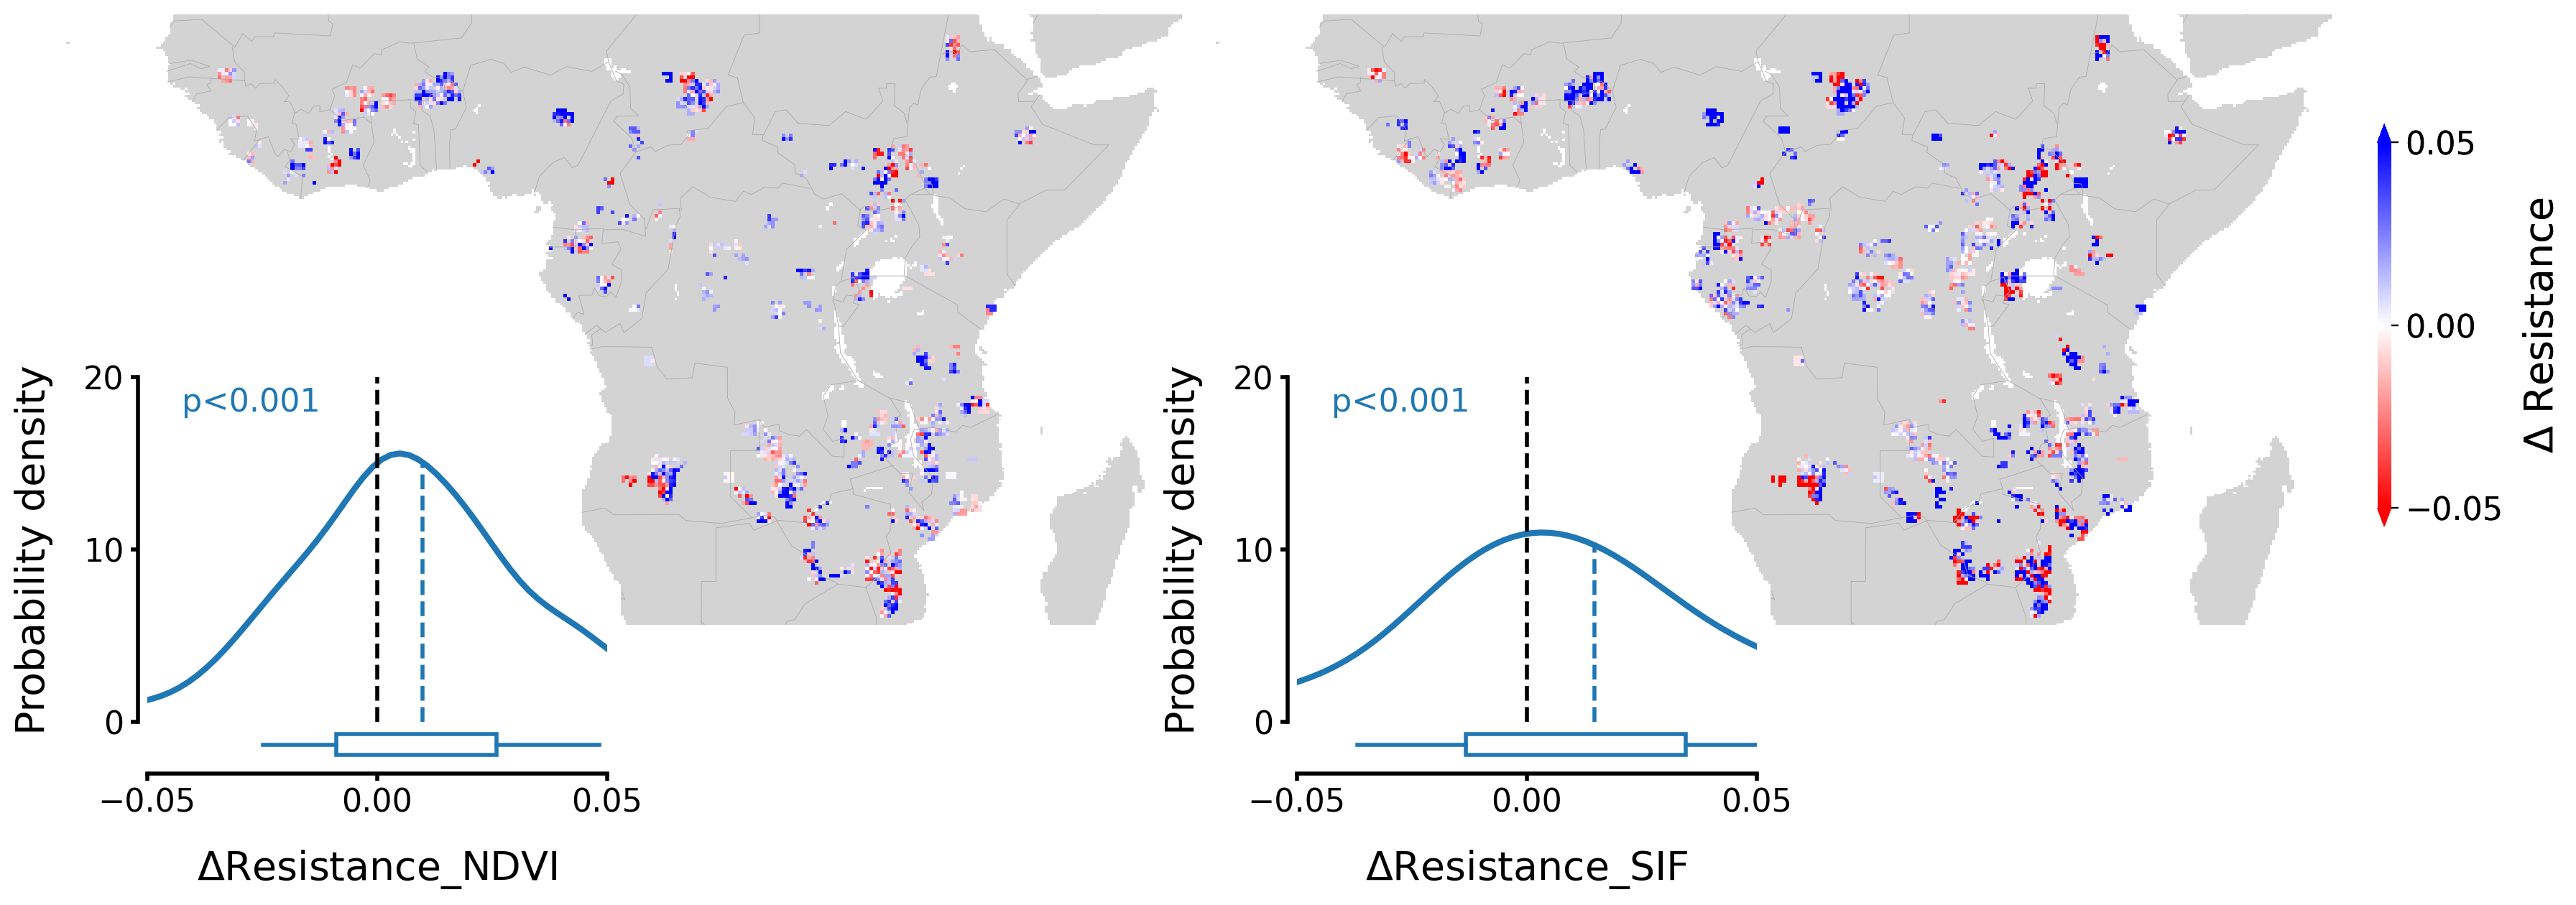

In [320]:
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 16}
#fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(16,12), sharex=False,sharey=False)
#return im_data, im_width, im_height, im_geotrans, im_proj
#(-25.37, 37.36, 51.42, -46.980000000000004)
#(-26.0, 25.0, 53.0, -40.0)
lon1 = -26
lon2 = 53
lat1 = -25
lat2 = 17

left, bottom, width, hegiht= 0, 0, 0.5,1
left1, bottom1, width1, hegiht1= 0.5, 0, 0.5,1
loc=[[left, bottom, width, hegiht],[left1, bottom1, width1, hegiht1]]
left2, bottom2, width2, hegiht2= 0.05, 0.15, 0.2,0.3
left3, bottom3, width3, hegiht3= 0.55, 0.15, 0.2,0.3
loc1=[[left2, bottom2, width2, hegiht2],[left3, bottom3, width3, hegiht3]]


#pp=[p_delta_LA[1],p_delta_LA[0]]
#pp1=[p_delta_LC[1],p_delta_LC[0]]
cl= np.array([(112,173,71),(169,209,142)])
cl1 = np.array([(251,153,143),(248,203,173)])
cl=cl/255
cl1=cl1/255
cl2=['C0','salmon']
res_name=['ndvi_res','csif_res']

fig = plt.figure(figsize=(16,8)) ##width, height default(8,6)
label=['$\Delta$ Resistance']
text=['a','b']
for i in range(2):
    ax = fig.add_subplot(loc[i])
    m = Basemap(llcrnrlon=lon1,llcrnrlat=lat1,urcrnrlon=lon2,urcrnrlat=lat2,ax=ax)
    m.drawlsmask(land_color='lightgray',ocean_color='none',lakes=True)
    m.drawcountries(linewidth=0.30, color='darkgrey')
    #m.drawmapboundary(fill_color='skyblue')
    #m.drawcoastlines(linewidth=0.50, color='black',zorder=40)
    norm = mcolors.TwoSlopeNorm(vmin=-0.05, vmax = 0.05, vcenter=0)
    im = m.imshow((delta[i]*mm[i])[32:200],cmap ='bwr_r',origin='upper',norm=norm)
    #im1 = m.imshow(LC_data[i],cmap ='bwr_r',origin='upper',norm=norm)
    #remove the broder of figure
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    #ax.text(0.01,0.9-i*0.008, text[i], transform = ax.transAxes,color='black',fontsize=18)

    #position=fig.add_axes([0.15])
    position=fig.add_axes([1.02,0.32,0.006,0.35])#左、底、宽、高
    #position=fig.add_axes([0.38,0.08,0.25,0.01])#左、底、宽、高
    cb=fig.colorbar(im,ax=ax,extend='both',shrink=0.3,pad=0.01,cax=position)#orientation='horizontal',
    cb.set_label(label[0],fontsize=20,labelpad=10)
    cb.ax.tick_params(labelsize=16) 
    cb.set_ticks(np.arange(-0.05,0.051,0.05)) 
    cb.outline.set_visible(False)
    #--------------------------------------添加 子图， pdf----------------------------------------------#
    ax1=fig.add_subplot(loc1[i])
    x=np.linspace(-1,1,1000)
    mean=np.nanmean(res_delta[i])
    delta_rav=gc.nanravel(res_delta[i])
    kenal=gaussian_kde(delta_rav)
    z=kenal.evaluate(x)
    z_mean=kenal.evaluate(mean)
    print(mean,z_mean)    
    ax1.plot(x,z,lw=3,color='C0')
    ax1.vlines(mean,0,z_mean,lw=2,ls='--',color='C0')
    ax1.vlines(0,0,25,lw=2,ls='--',color='black')
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    #ax1.spines['bottom'].set_visible(False)
    ax1.text(0.13,0.35, "p<0.001", fontsize=16,transform = ax.transAxes,color='C0')
    
    #ax1.legend(fontsize=12,loc='upper left',frameon=False)
    xlabel=['$\Delta$Resistance_NDVI','$\Delta$Resistance_SIF']
    #ax.text(-0.17,1, '(c)', transform = ax.transAxes,color='black',fontsize=18)
    ax1=plt.gca()
    ax1.yaxis.set_ticks_position('left')
    ax1.spines['left'].set_position(('data',-0.052))
    ax1.xaxis.set_ticks_position('bottom')
    ax1.spines['bottom'].set_position(('data',-3))
    ax1.set_ylim(0,20)
    ax1.set_xlim(-0.05,0.05)
    ax1.set_xticks(np.arange(-0.05,0.051,0.05))
    ax1.set_yticks(np.arange(0,20.1,10))
    ax1.set_ylabel('Probability density',labelpad=15)
    ax1.set_xlabel(xlabel[i],labelpad=15)
    ax1.tick_params(labelsize=16)
    ax1.xaxis.label.set_size(20)
    ax1.yaxis.label.set_size(20)
    ax1.xaxis.set_tick_params(width=2)
    ax1.yaxis.set_tick_params(width=2)
    ax1.spines['left'].set_linewidth(2)
    ax1.spines['bottom'].set_linewidth(2)
    #ax.text(0.05,0.95, text[i], fontsize=24,family='SimHei',weight='black',color='black',transform = ax.transAxes)
    ax1.set(facecolor='none')
    #position=fig.add_axes([1.02,0.32,0.006,0.35])#左、底、宽、高
    if i ==0:
        ax2=fig.add_axes([0.05,0.1,0.2,0.06])#左，底，宽，高
        ax2.set_xlim(-0.05,0.05)
        ax2.set_xticks(np.arange(-0.05,0.05,0.05))
        ax2.axis('off')
    else:
        ax2=fig.add_axes([0.55,0.1,0.2,0.06])#左，底，宽，高
        ax2.set_xlim(-0.05,0.05)
        ax2.set_xticks(np.arange(-0.05,0.05,0.05))
        ax2.axis('off')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.tick_params(bottom=True,top=False, left=False, right=False)#隐藏刻度线
    ax2.spines['bottom'].set_visible(True)
    bplot=ax2.boxplot(res_delta[i],
                      vert=False,
                      whis=(10,90),                
                      widths=0.3,
                      patch_artist=True,
                      showmeans=False,
                      meanprops = {'marker':'o','markerfacecolor':'C0',"markeredgecolor":'C0',"markersize":15,"alpha":0}, # 设置均值点的属性，点的形状、填充色
                      medianprops={'linewidth':'0.5',"color":'C0',"alpha":0},
                      boxprops={"facecolor": 'none', "edgecolor": 'C0',"linewidth":2,"alpha":1},
                      capprops=None,
                      whiskerprops={'linewidth':'2','color':'C0'},
                      showcaps=False,# 是否显示箱线图顶端和末端的两条线，默认显示
                      showfliers = False,
                      flierprops = {'marker':'+','markersize':'3','markeredgecolor':'C0','color':'C0'})
    ax2.set(facecolor='none')

#fig.savefig("E:/iCloudDrive/博后工作/文章/Elephant_disturb/Fig/reviseV2/Fig1_resistance patterns_main_240116.tif", dpi=600, bbox_inches = 'tight')

## Fig-relative_delta_resistance

In [698]:
data_th=[relative_delta[0],relative_delta[1]]

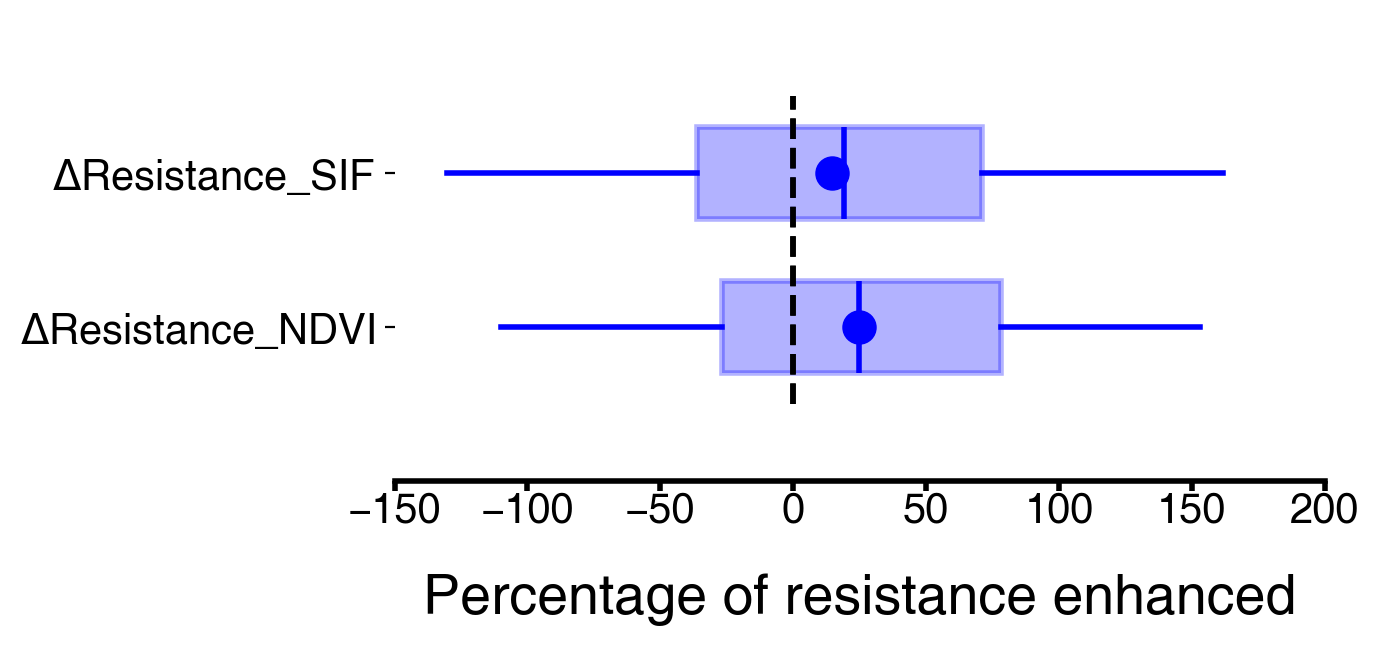

In [699]:
import matplotlib.patches as mpatches
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6,3), sharex=False,sharey=False) ##width, height default(8,6)
#fig.subplots_adjust(wspace=0.2,hspace=0.4, left=None, bottom=None, right=None, top=None)
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 18}
plt.rc('font', **font)  # pass in the font dict as kwargs

cl1 = np.array([0,0,255])
cl2 = np.array([0,0,255])
cl=[cl1/255,cl2/255]

ps=[[1],[1.5]]
x1=[1,1.5]
for i in range(2):
    ax.boxplot(data_th[i],
                vert=False,
                whis=(10,90),                
                widths=0.3,
                patch_artist=True,
                showmeans=False,
                meanprops = {'marker':'o','markerfacecolor':'blue',"markeredgecolor":'blue',"markersize":15,"alpha":0}, # 设置均值点的属性，点的形状、填充色
                medianprops={'linewidth':'2',"color":'blue',"alpha":1},
                boxprops={"facecolor": 'blue', "edgecolor": 'blue',"linewidth":2,"alpha":0.3},
                capprops=None,
                whiskerprops={'linewidth':'2','color':'blue'},
                showcaps=False,# 是否显示箱线图顶端和末端的两条线，默认显示
                showfliers = False,
                flierprops = {'marker':'+','markersize':'3','markeredgecolor':'blue','color':'blue'},
                positions=ps[i])
    patch=mpatches.Patch(color=cl[i],label='Short')
    ax.scatter(np.mean(data_th[i]),x1[i],color= 'blue',s=130)
    ax.vlines(0,0.75,1.75,lw=2,ls='--',color='black')
labels = ['$\Delta$Resistance_NDVI', '$\Delta$Resistance_SIF']
#lab=['short','tall','short','tall']
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks(x1,labels=labels,rotation=0)
ax.xaxis.set_tick_params(labelsize=15,pad=0)
ax.yaxis.set_tick_params(labelsize=15)
ax.tick_params(bottom=True,top=False, left=True, right=False)#隐藏刻度线

ax.set_xlabel('Percentage of resistance enhanced',size=20,labelpad=15)
ax.set_xlim(-150,200)
ax.set_xticks(np.arange(-150,201,50))

ax.xaxis.set_tick_params(width=2)
ax.spines['bottom'].set_linewidth(2)


## Fig_combine

0.009874425666582844 [15.06742791]
0.014691344419456537 [10.25682018]


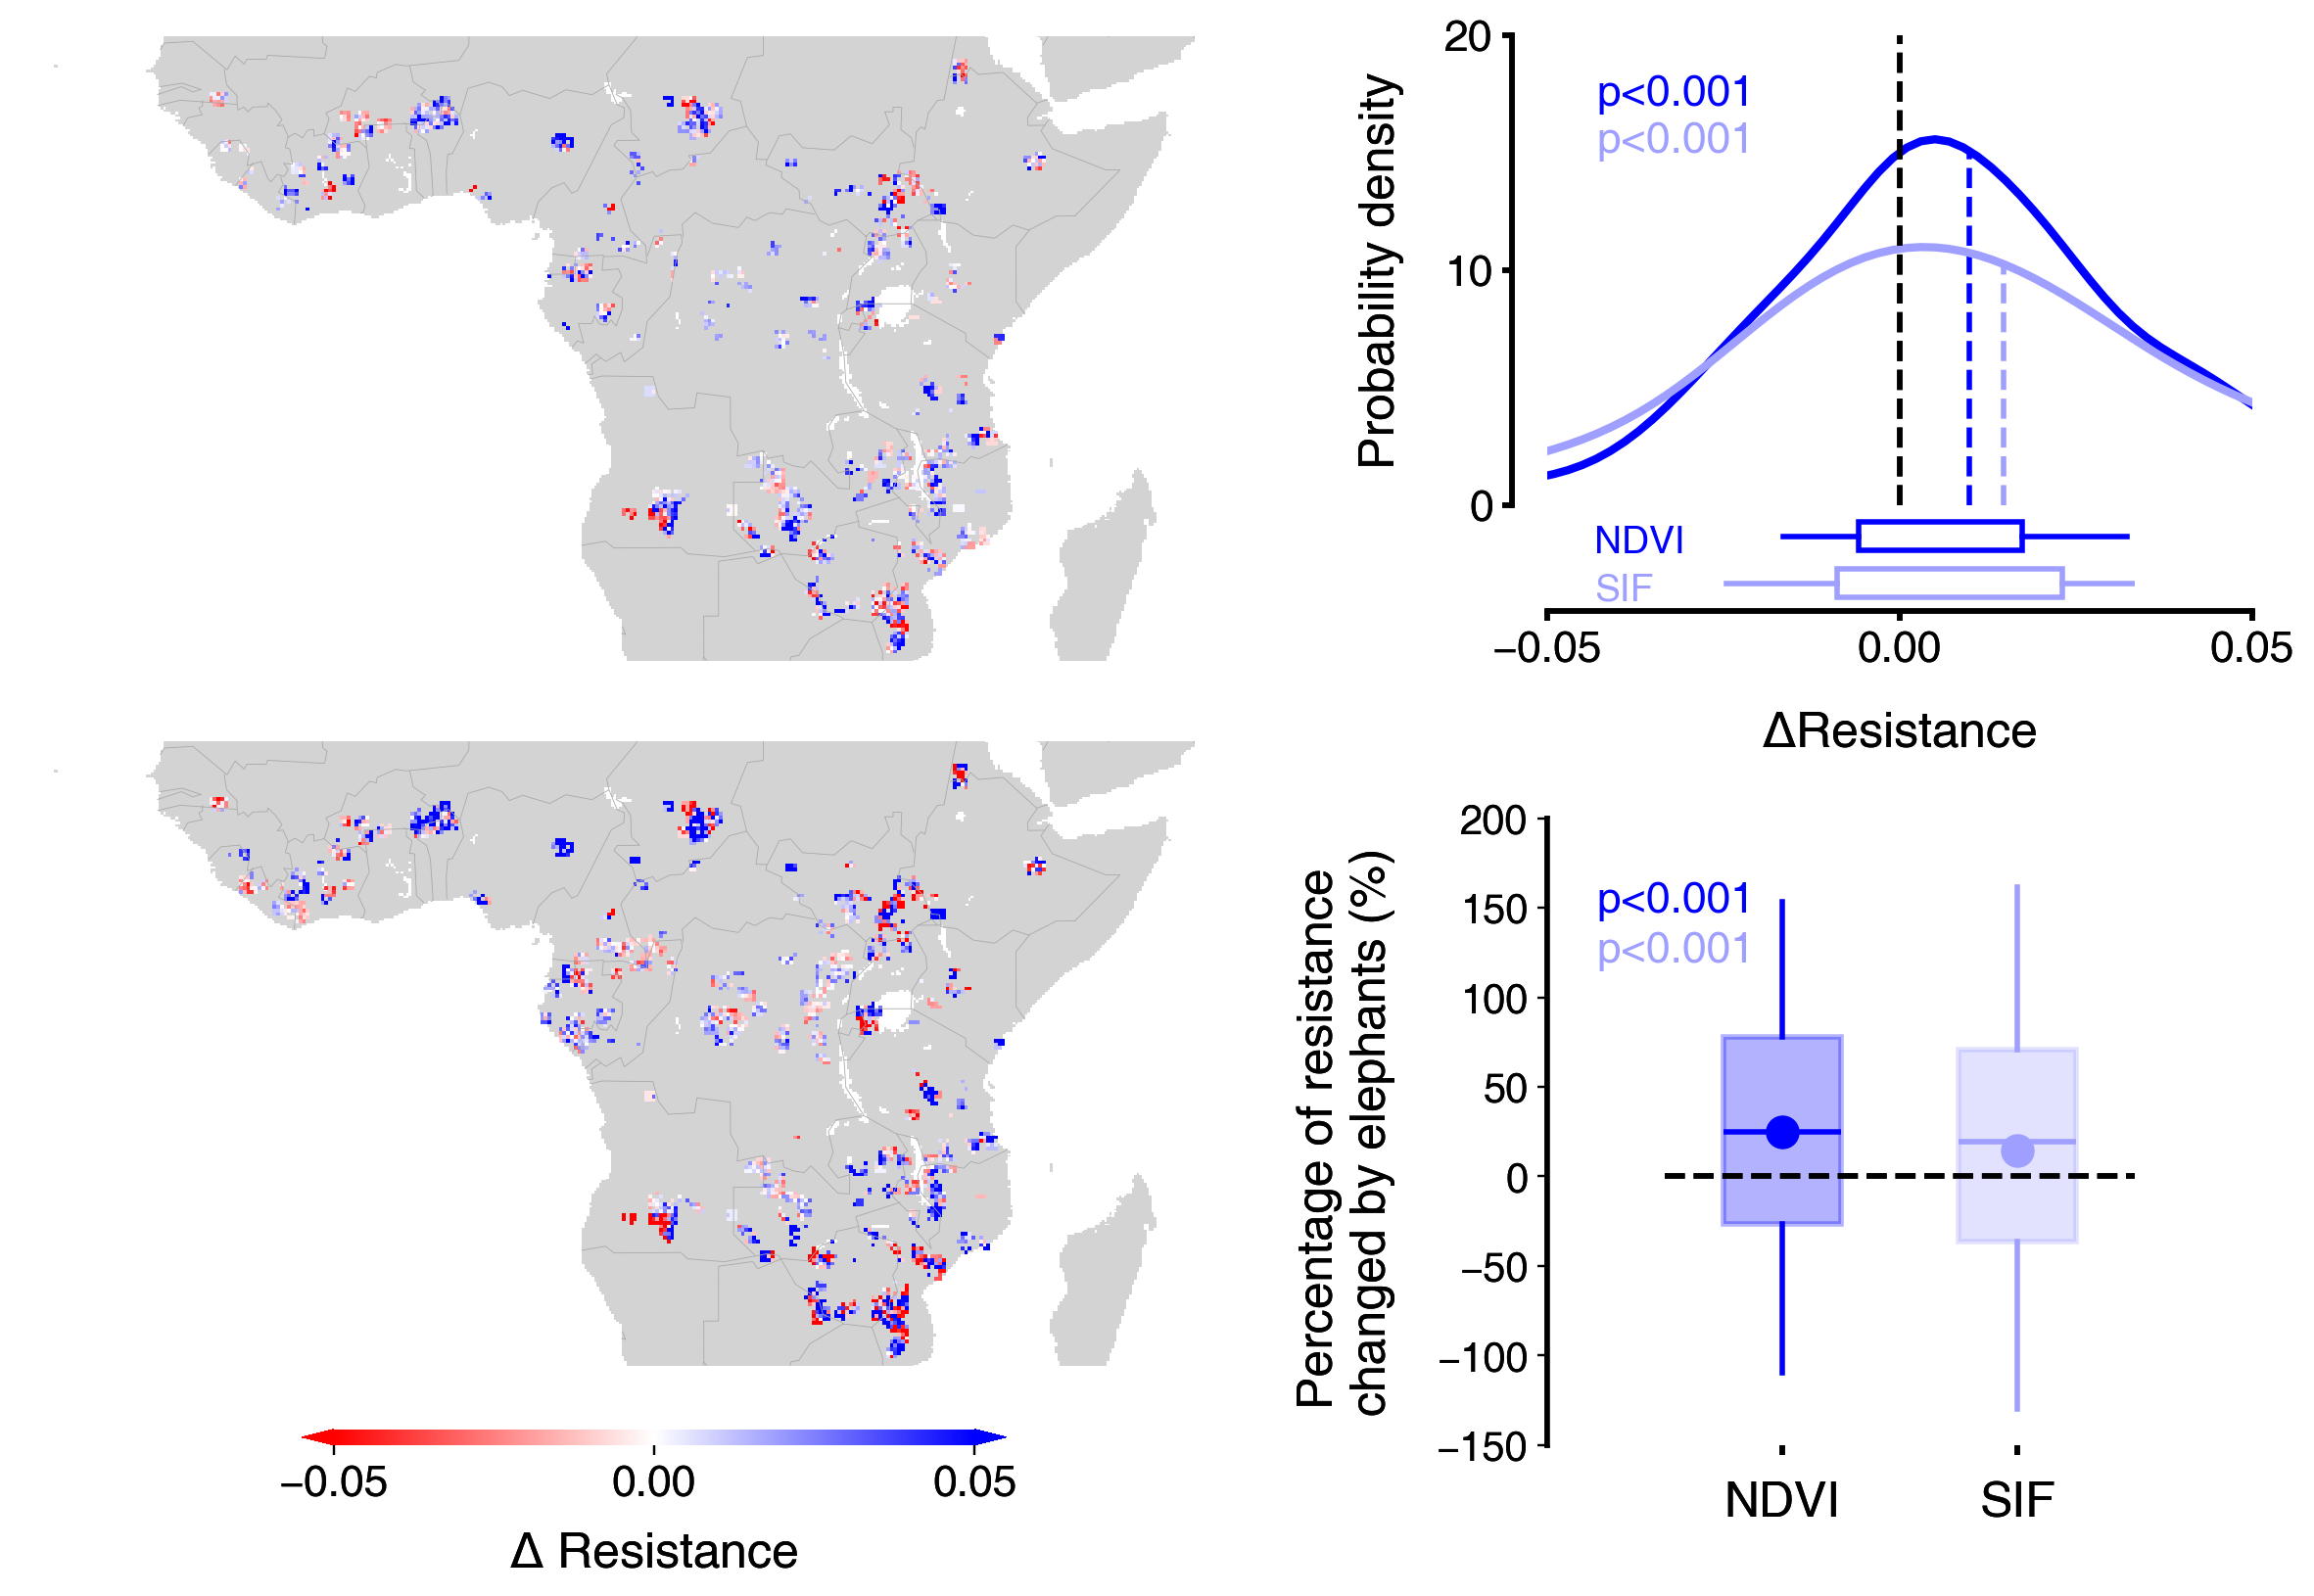

In [706]:
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 16}

lon1 = -26
lon2 = 53
lat1 = -25
lat2 = 17

left, bottom, width, hegiht= 0, 0, 0.5,1
left1, bottom1, width1, hegiht1= 0, -0.45, 0.5,1
loc=[[left, bottom, width, hegiht],[left1, bottom1, width1, hegiht1]]
left2, bottom2, width2, hegiht2= 0.65, 0.4, 0.3,0.3
left3, bottom3, width3, hegiht3= 0.65, -0.2, 0.3,0.4
loc1=[[left2, bottom2, width2, hegiht2],[left3, bottom3, width3, hegiht3]]

cl= np.array([(0,0,255),(159,159,255)])
cl=cl/255

cl1= np.array([(0,0,255),(109,109,255)])
cl1=cl1/255

res_name=['ndvi_res','csif_res']

fig = plt.figure(figsize=(12,8)) ##width, height default(8,6)
label=['$\Delta$ Resistance']
text=['a','b']
for i in range(2):
    ax = fig.add_subplot(loc[i])
    m = Basemap(llcrnrlon=lon1,llcrnrlat=lat1,urcrnrlon=lon2,urcrnrlat=lat2,ax=ax)
    m.drawlsmask(land_color='lightgray',ocean_color='none',lakes=True)
    m.drawcountries(linewidth=0.30, color='darkgrey')
    norm = mcolors.TwoSlopeNorm(vmin=-0.05, vmax = 0.05, vcenter=0)
    im = m.imshow((delta[i]*mm[i])[32:200],cmap ='bwr_r',origin='upper',norm=norm)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    position=fig.add_axes([0.12,-0.2,0.3,0.01])#左、底、宽、高
    cb=fig.colorbar(im,ax=ax,extend='both',shrink=0.3,pad=0.01,orientation='horizontal',cax=position)#orientation='horizontal',
    cb.set_label(label[0],fontsize=18,labelpad=10)
    cb.ax.tick_params(labelsize=16) 
    cb.set_ticks(np.arange(-0.05,0.051,0.05)) 
    cb.outline.set_visible(False)
    #--------------------------------------添加 子图， pdf----------------------------------------------#
    ax1=fig.add_subplot(loc1[0])
    x=np.linspace(-1,1,1000)
    mean=np.nanmean(res_delta[i])
    delta_rav=gc.nanravel(res_delta[i])
    kenal=gaussian_kde(delta_rav)
    z=kenal.evaluate(x)
    z_mean=kenal.evaluate(mean)
    print(mean,z_mean)

    xlabel=['$\Delta$Resistance','$\Delta$Resistance_SIF']
    ax1.plot(x,z,lw=3,color=cl[i])
    ax1.vlines(mean,0,z_mean,lw=2,ls='--',color=cl[i])
    ax1.vlines(0,0,25,lw=2,ls='--',color='black')
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    
    ax1.text(0.07,0.85-i*0.1, "p<0.001", fontsize=16,transform = ax1.transAxes,color=cl[i])
    
    ax1=plt.gca()
    ax1.yaxis.set_ticks_position('left')
    ax1.spines['left'].set_position(('data',-0.055))
    ax1.xaxis.set_ticks_position('bottom')
    ax1.spines['bottom'].set_position(('data',-4.5))
    ax1.set_ylim(0,18)
    ax1.set_xlim(-0.05,0.05)
    ax1.set_xticks(np.arange(-0.05,0.051,0.05))
    ax1.set_yticks(np.arange(0,20.1,10))
    ax1.set_ylabel('Probability density',labelpad=15)
    ax1.set_xlabel(xlabel[0],labelpad=15)
    ax1.tick_params(labelsize=16)
    ax1.xaxis.label.set_size(18)
    ax1.yaxis.label.set_size(18)
    ax1.xaxis.set_tick_params(width=2)
    ax1.yaxis.set_tick_params(width=2)
    ax1.spines['left'].set_linewidth(2)
    ax1.spines['bottom'].set_linewidth(2)
    ax1.set(facecolor='none')
    if i ==0:
        ax2=fig.add_axes([0.7,0.35,0.2,0.06])#左，底，宽，高
        ax2.set_xlim(-0.05,0.05)
        ax2.set_xticks(np.arange(-0.05,0.05,0.05))
        ax2.axis('off')
        ax2.text(-0.15,0.32, "NDVI", fontsize=14,transform = ax2.transAxes,color=cl[i])#transform = ax1.transAxes,
    else:
        ax2=fig.add_axes([0.7,0.32,0.2,0.06])#左，底，宽，高
        ax2.set_xlim(-0.05,0.05)
        ax2.set_xticks(np.arange(-0.05,0.05,0.05))
        ax2.axis('off')
        ax2.text(-0.15,0.315, "SIF", fontsize=14,transform = ax2.transAxes,color=cl[i])#
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(True)
    bplot=ax2.boxplot(res_delta[i],
                      vert=False,
                      whis=(10,90),
                      widths=0.3,
                      patch_artist=True,
                      showmeans=False,
                      meanprops = {'marker':'o','markerfacecolor':'C0',"markeredgecolor":'C0',"markersize":15,"alpha":0}, # 设置均值点的属性，点的形状、填充色
                      medianprops={'linewidth':'0.5',"color":'C0',"alpha":0},
                      boxprops={"facecolor": 'none', "edgecolor": cl[i],"linewidth":2,"alpha":1},
                      capprops=None,
                      whiskerprops={'linewidth':'2','color':cl[i]},
                      showcaps=False,# 是否显示箱线图顶端和末端的两条线，默认显示
                      showfliers = False,
                      flierprops = {'marker':'+','markersize':'3','markeredgecolor':cl[i],'color':cl[i]})
    ax2.set(facecolor='none')
    
    ax3=fig.add_subplot(loc1[1])
    ps=[[1],[1.5]]
    x1=[1,1.5]
    x2=[1.25]
    for i in range(2):
        ax3.boxplot(data_th[i],
                    vert=True,
                    whis=(10,90),                
                    widths=0.25,
                    patch_artist=True,
                    showmeans=False,
                    meanprops = {'marker':'o','markerfacecolor':'blue',"markeredgecolor":'blue',"markersize":15,"alpha":0}, # 设置均值点的属性，点的形状、填充色
                    medianprops={'linewidth':'2',"color":cl[i],"alpha":1},
                    boxprops={"facecolor": cl[i], "edgecolor": cl[i],"linewidth":2,"alpha":0.3},
                    capprops=None,
                    whiskerprops={'linewidth':'2','color':cl[i]},
                    showcaps=False,# 是否显示箱线图顶端和末端的两条线，默认显示
                    showfliers = False,
                    flierprops = {'marker':'+','markersize':'3','markeredgecolor':cl[i],'color':cl[i]},
                    positions=ps[i])
        patch=mpatches.Patch(color=cl[i],label='Short')
        ax3.scatter(x1[i],np.mean(data_th[i]),color= cl[i],s=130)
        ax3.hlines(0,0.75,1.75,lw=2,ls='--',color='black')
        ax3.text(0.07,0.85-i*0.08, "p<0.001", fontsize=16,transform = ax3.transAxes,color=cl[i])
    labels = ['NDVI', 'SIF']
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    ax3.set_xticks(x1,labels=labels,rotation=0)
    ax3.xaxis.set_tick_params(labelsize=18,pad=10)
    ax3.yaxis.set_tick_params(labelsize=15)
    ax3.tick_params(bottom=True,top=False, left=True, right=False)#隐藏刻度线
    #ax3.set_xlabel('$\Delta$Resistance',labelpad=10)

    ax3.set_ylabel('Percentage of resistance \nchanged by elephants (%)',size=18,labelpad=15)
    ax3.set_ylim(-150,200)
    ax3.set_yticks(np.arange(-150,201,50))

    ax3.xaxis.set_tick_params(width=2)
    ax3.spines['left'].set_linewidth(2)

#fig.savefig("E:/iCloudDrive/博后工作/文章/Elephant_disturb/Fig/reviseV2/Fig1_resistance patterns_main_240116.tif", dpi=600, bbox_inches = 'tight')

## Fig_resistance DAA

0.9884493598452019 [9.61858255]
0.9605814084821915 [11.63568596]
0.9590336216344644 [6.61869993]
0.9335580834638013 [5.6418332]


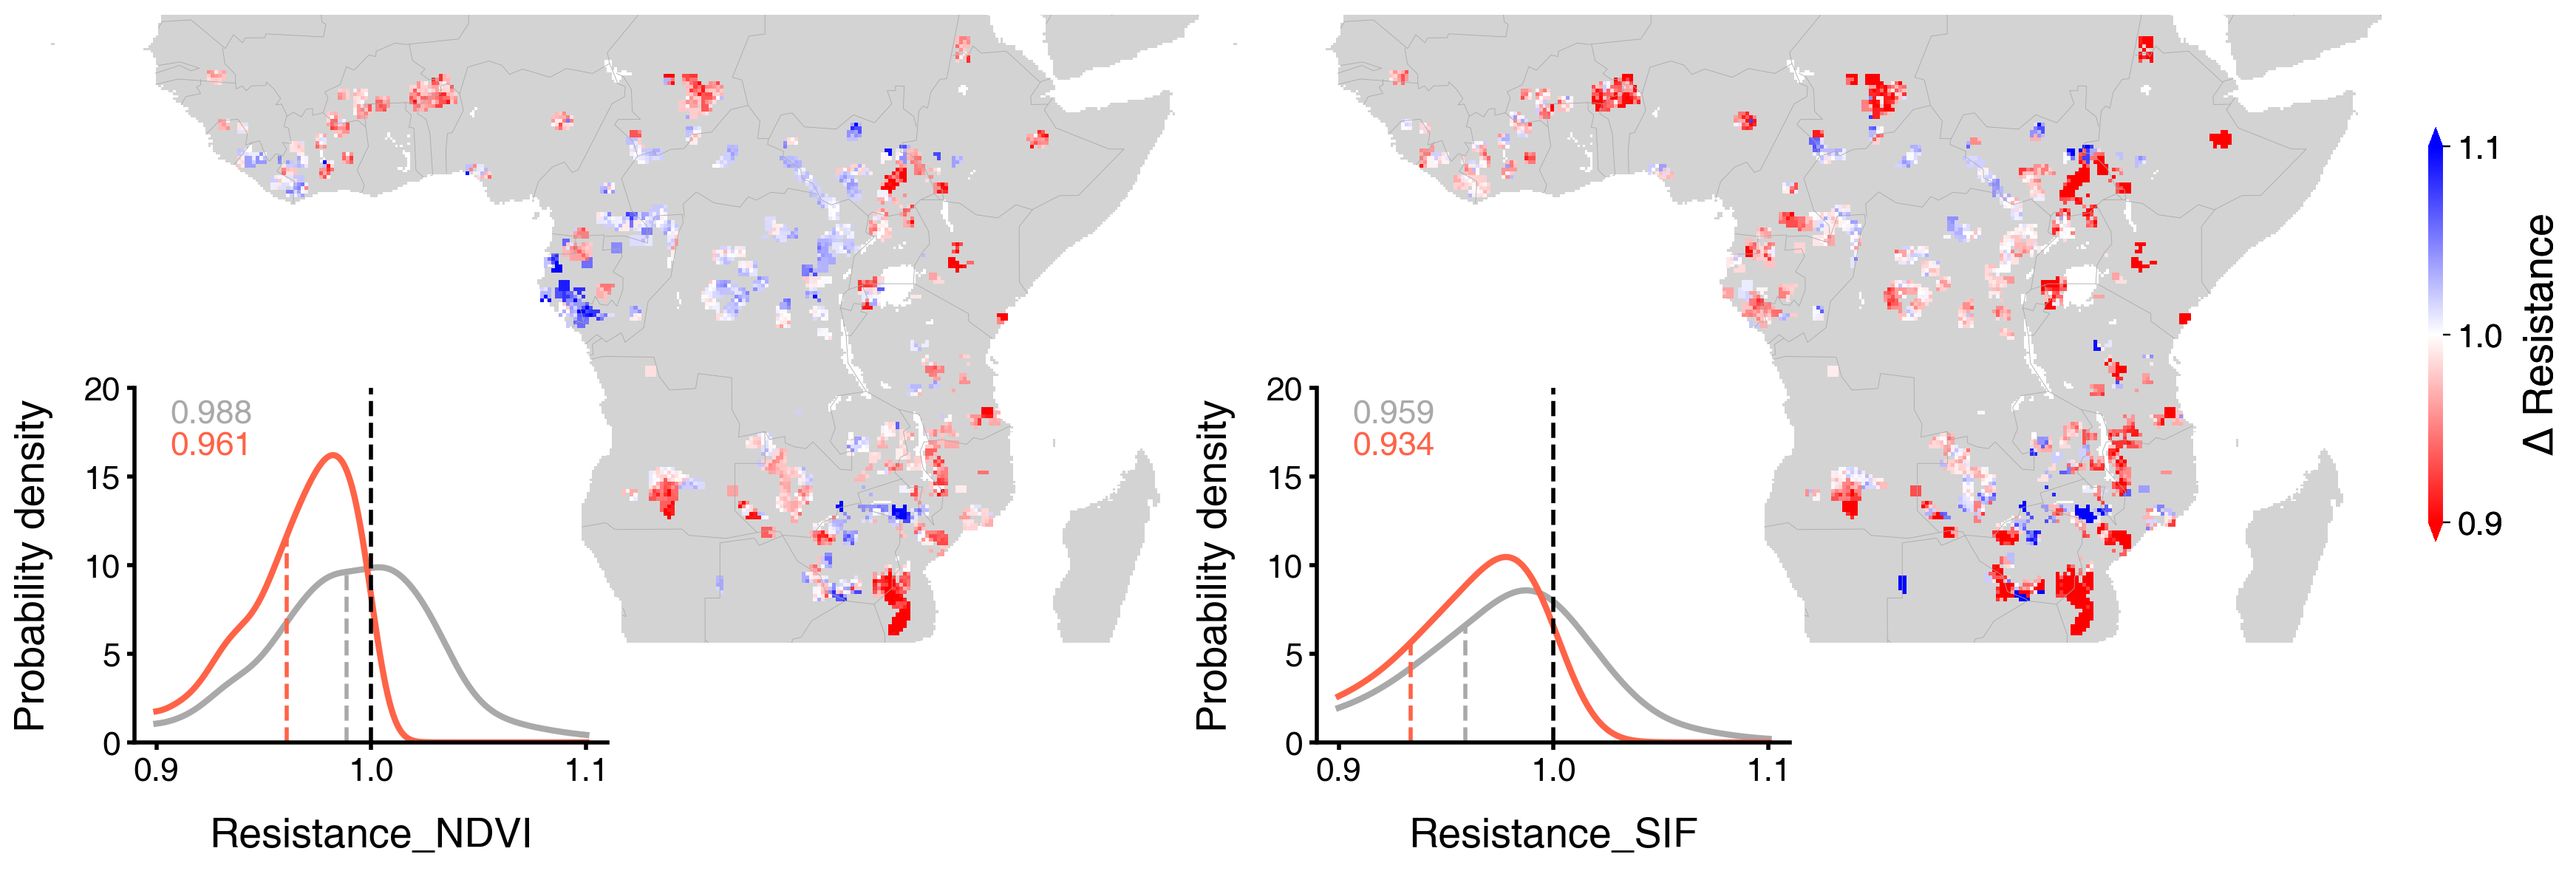

In [742]:
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 16}
#fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(16,12), sharex=False,sharey=False)
#return im_data, im_width, im_height, im_geotrans, im_proj
#(-25.37, 37.36, 51.42, -46.980000000000004)
#(-26.0, 25.0, 53.0, -40.0)
lon1 = -26
lon2 = 53
lat1 = -25
lat2 = 17

left, bottom, width, hegiht= 0, 0, 0.5,1
left1, bottom1, width1, hegiht1= 0.5, 0, 0.5,1
loc=[[left, bottom, width, hegiht],[left1, bottom1, width1, hegiht1]]
left2, bottom2, width2, hegiht2= 0.05, 0.15, 0.2,0.3
left3, bottom3, width3, hegiht3= 0.55, 0.15, 0.2,0.3
loc1=[[left2, bottom2, width2, hegiht2],[left3, bottom3, width3, hegiht3]]


#pp=[p_delta_LA[1],p_delta_LA[0]]
#pp1=[p_delta_LC[1],p_delta_LC[0]]
cl= np.array([(112,173,71),(169,209,142)])
cl1 = np.array([(251,153,143),(248,203,173)])
cl=cl/255
cl1=cl1/255
cl2=['C0','salmon']
res_name=['ndvi_res','csif_res']

fig = plt.figure(figsize=(16,8)) ##width, height default(8,6)
label=['$\Delta$ Resistance']
text=['a','b']
for i in range(2):
    ax = fig.add_subplot(loc[i])
    m = Basemap(llcrnrlon=lon1,llcrnrlat=lat1,urcrnrlon=lon2,urcrnrlat=lat2,ax=ax)
    m.drawlsmask(land_color='lightgray',ocean_color='none',lakes=True)
    m.drawcountries(linewidth=0.30, color='darkgrey')
    #m.drawmapboundary(fill_color='skyblue')
    #m.drawcoastlines(linewidth=0.50, color='black',zorder=40)
    norm = mcolors.TwoSlopeNorm(vmin=0.9, vmax = 1.1, vcenter=1)
    im = m.imshow(d_DAA[i][32:200],cmap ='bwr_r',origin='upper',norm=norm)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    position=fig.add_axes([1.02,0.32,0.006,0.35])#左、底、宽、高
    #position=fig.add_axes([0.38,0.08,0.25,0.01])#左、底、宽、高
    cb=fig.colorbar(im,ax=ax,extend='both',shrink=0.3,pad=0.01,cax=position)#orientation='horizontal',
    cb.set_label(label[0],fontsize=20,labelpad=10)
    cb.ax.tick_params(labelsize=16) 
    cb.set_ticks(np.arange(0.9,1.11,0.1)) 
    cb.outline.set_visible(False)
    #--------------------------------------添加 子图， pdf----------------------------------------------#
    ax1=fig.add_subplot(loc1[i])
    x=np.linspace(0.9,1.1,1000)
    ###所有grids
    mean=np.nanmean(res_daa[i])
    delta_rav=gc.nanravel(res_daa[i])
    kenal=gaussian_kde(delta_rav)
    z=kenal.evaluate(x)
    z_mean=kenal.evaluate(mean)
    print(mean,z_mean)
    ax1.plot(x,z,lw=3,color='darkgrey')
    ax1.vlines(mean,0,z_mean,lw=2,ls='--',color='darkgrey')
    ax1.text(0.13,0.35, "{:.3f}".format(mean), fontsize=16,transform = ax.transAxes,color='darkgrey')
    ###仅植被下降的grids
    mean1=np.nanmean(res_daa_positive[i])
    delta_rav=gc.nanravel(res_daa_positive[i])
    kenal=gaussian_kde(delta_rav)
    z1=kenal.evaluate(x)
    z_mean1=kenal.evaluate(mean1)
    print(mean1,z_mean1)
    ax1.plot(x,z1,lw=3,color='tomato')
    ax1.vlines(mean1,0,z_mean1,lw=2,ls='--',color='tomato')
    ax1.text(0.13,0.30, "{:.3f}".format(mean1), fontsize=16,transform = ax.transAxes,color='tomato')
    
    xlabel=['Resistance_NDVI','Resistance_SIF']
    ax1.vlines(1,0,25,lw=2,ls='--',color='black')
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    #ax1.spines['bottom'].set_visible(False)
    
    ax1=plt.gca()
    ax1.yaxis.set_ticks_position('left')
    ax1.set_ylim(0,20)
    ax1.set_yticks(np.arange(0,20.1,5))
    ax1.set_ylabel('Probability density',labelpad=15)
    ax1.set_xlabel(xlabel[i],labelpad=15)
    ax1.tick_params(labelsize=16)
    ax1.xaxis.label.set_size(20)
    ax1.yaxis.label.set_size(20)
    ax1.xaxis.set_tick_params(width=2)
    ax1.yaxis.set_tick_params(width=2)
    ax1.spines['left'].set_linewidth(2)
    ax1.spines['bottom'].set_linewidth(2)
    #ax.text(0.05,0.95, text[i], fontsize=24,family='SimHei',weight='black',color='black',transform = ax.transAxes)
    ax1.set(facecolor='none')
#fig.savefig("E:/iCloudDrive/博后工作/文章/Elephant_disturb/Fig/reviseV2/Fig1_resistance patterns_main_240116.tif", dpi=600, bbox_inches = 'tight')

## Fig resistance DEAA

0.9913044197410956 [10.46316017]
0.9653734222610153 [7.38707387]


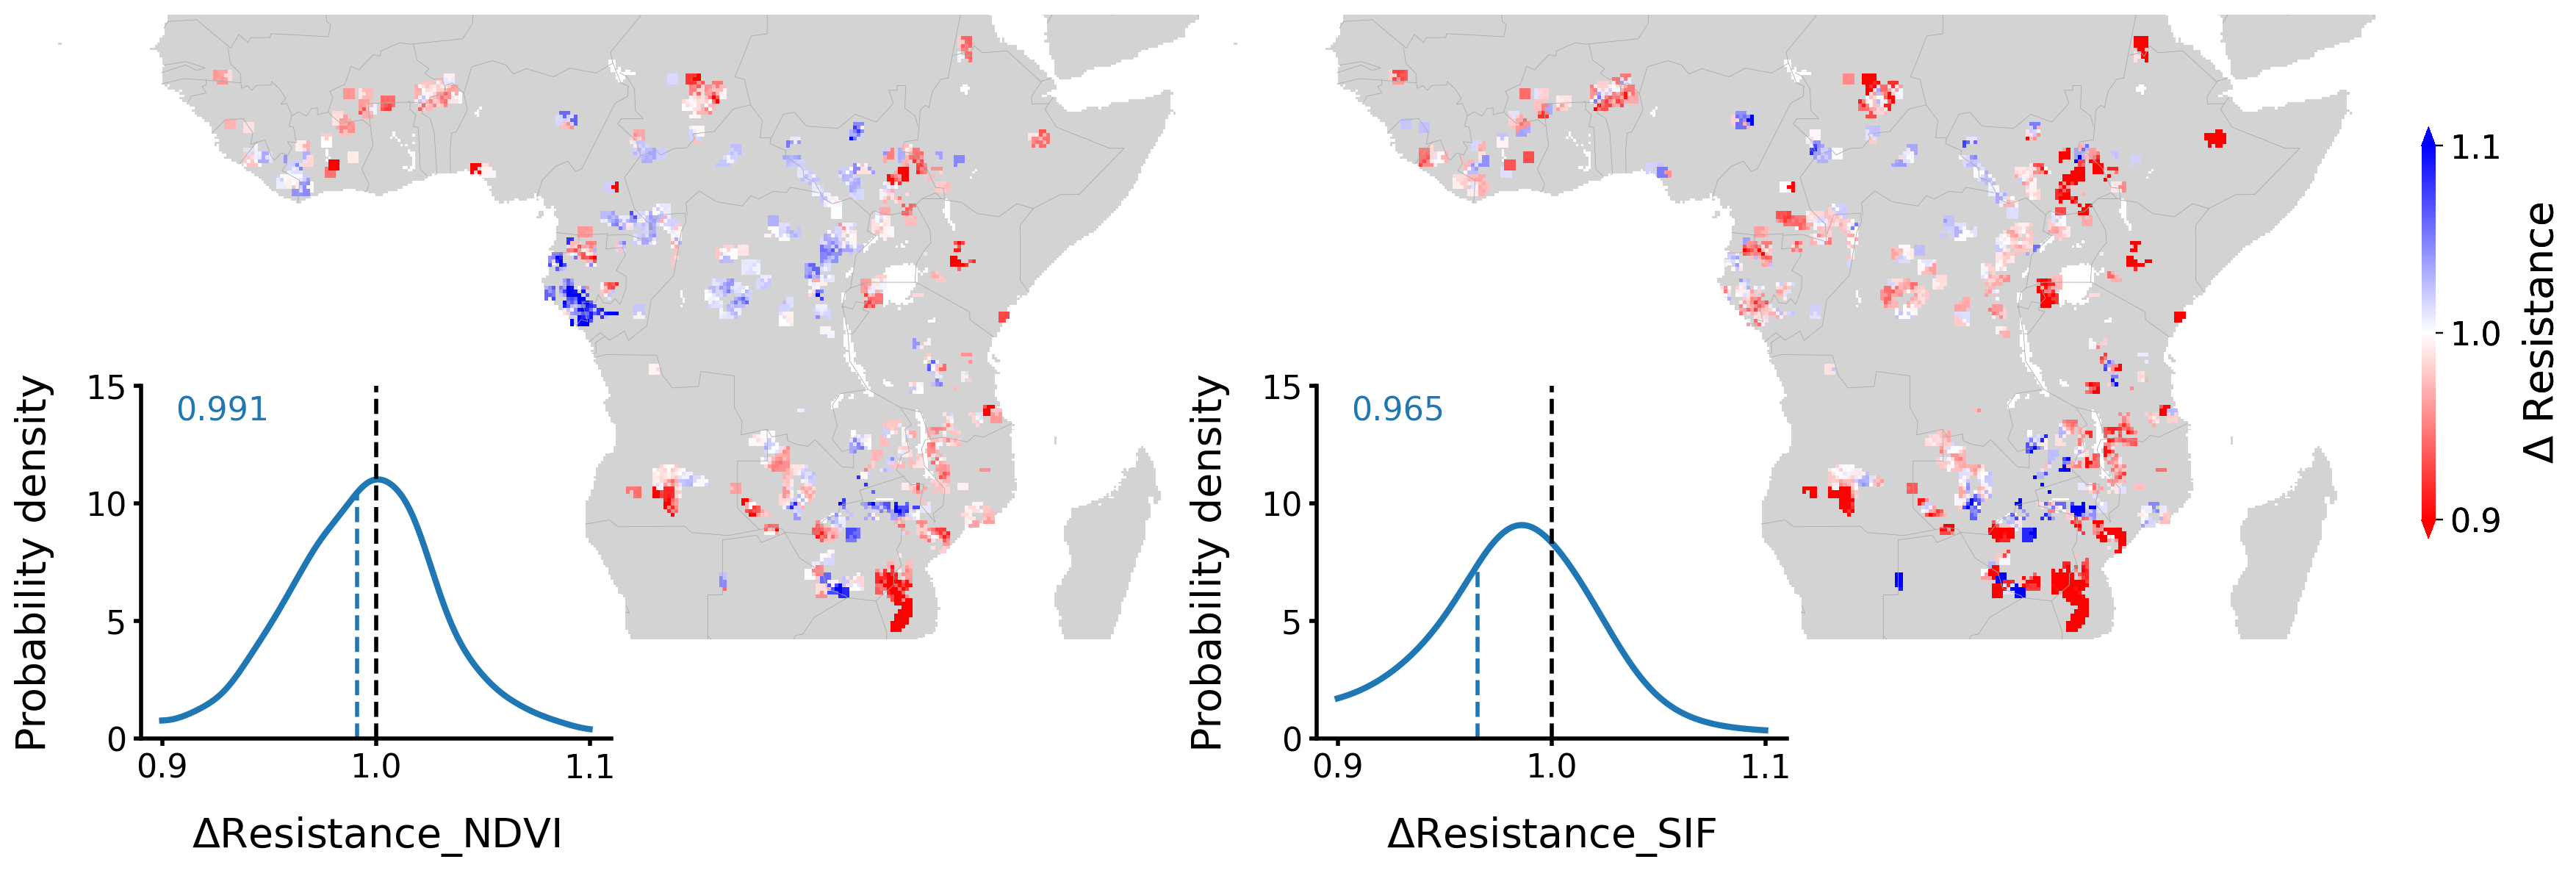

In [236]:
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 16}
#fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(16,12), sharex=False,sharey=False)
#return im_data, im_width, im_height, im_geotrans, im_proj
#(-25.37, 37.36, 51.42, -46.980000000000004)
#(-26.0, 25.0, 53.0, -40.0)
lon1 = -26
lon2 = 53
lat1 = -25
lat2 = 17

left, bottom, width, hegiht= 0, 0, 0.5,1
left1, bottom1, width1, hegiht1= 0.5, 0, 0.5,1
loc=[[left, bottom, width, hegiht],[left1, bottom1, width1, hegiht1]]
left2, bottom2, width2, hegiht2= 0.05, 0.15, 0.2,0.3
left3, bottom3, width3, hegiht3= 0.55, 0.15, 0.2,0.3
loc1=[[left2, bottom2, width2, hegiht2],[left3, bottom3, width3, hegiht3]]


#pp=[p_delta_LA[1],p_delta_LA[0]]
#pp1=[p_delta_LC[1],p_delta_LC[0]]
cl= np.array([(112,173,71),(169,209,142)])
cl1 = np.array([(251,153,143),(248,203,173)])
cl=cl/255
cl1=cl1/255
cl2=['C0','salmon']
res_name=['ndvi_res','csif_res']

fig = plt.figure(figsize=(16,8)) ##width, height default(8,6)
label=['$\Delta$ Resistance']
text=['a','b']
for i in range(2):
    ax = fig.add_subplot(loc[i])
    m = Basemap(llcrnrlon=lon1,llcrnrlat=lat1,urcrnrlon=lon2,urcrnrlat=lat2,ax=ax)
    m.drawlsmask(land_color='lightgray',ocean_color='none',lakes=True)
    m.drawcountries(linewidth=0.30, color='darkgrey')
    #m.drawmapboundary(fill_color='skyblue')
    #m.drawcoastlines(linewidth=0.50, color='black',zorder=40)
    norm = mcolors.TwoSlopeNorm(vmin=0.9, vmax = 1.1, vcenter=1)
    im = m.imshow(d_DEAA[i][32:200],cmap ='bwr_r',origin='upper',norm=norm)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    position=fig.add_axes([1.02,0.32,0.006,0.35])#左、底、宽、高
    #position=fig.add_axes([0.38,0.08,0.25,0.01])#左、底、宽、高
    cb=fig.colorbar(im,ax=ax,extend='both',shrink=0.3,pad=0.01,cax=position)#orientation='horizontal',
    cb.set_label(label[0],fontsize=20,labelpad=10)
    cb.ax.tick_params(labelsize=16) 
    cb.set_ticks(np.arange(0.9,1.11,0.1)) 
    cb.outline.set_visible(False)
    #--------------------------------------添加 子图， pdf----------------------------------------------#
    ax1=fig.add_subplot(loc1[i])
    x=np.linspace(0.9,1.1,1000)
    mean=np.nanmean(res_deaa[i])
    delta_rav=gc.nanravel(res_deaa[i])
    kenal=gaussian_kde(delta_rav)
    z=kenal.evaluate(x)
    z_mean=kenal.evaluate(mean)
    print(mean,z_mean)

    xlabel=['$\Delta$Resistance_NDVI','$\Delta$Resistance_SIF']
    ax1.plot(x,z,lw=3,color='C0')
    ax1.vlines(mean,0,z_mean,lw=2,ls='--',color='C0')
    ax1.vlines(1,0,25,lw=2,ls='--',color='black')
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    #ax1.spines['bottom'].set_visible(False)
    ax1.text(0.13,0.35, "{:.3f}".format(mean), fontsize=16,transform = ax.transAxes,color='C0')
    #ax1.legend(fontsize=12,loc='upper left',frameon=False)

    #ax.text(-0.17,1, '(c)', transform = ax.transAxes,color='black',fontsize=18)
    ax1=plt.gca()
    ax1.yaxis.set_ticks_position('left')
    #ax1.spines['left'].set_position(('data',-0.052))
    #ax1.xaxis.set_ticks_position('bottom')
    #ax1.spines['bottom'].set_position(('data',-3))
    ax1.set_ylim(0,15)
    ax1.set_yticks(np.arange(0,15.1,5))
    #ax1.set_xlim(-0.05,0.05)
    #ax1.set_xticks(np.arange(-0.05,0.051,0.05))
    ax1.set_ylabel('Probability density',labelpad=15)
    ax1.set_xlabel(xlabel[i],labelpad=15)
    ax1.tick_params(labelsize=16)
    ax1.xaxis.label.set_size(20)
    ax1.yaxis.label.set_size(20)
    ax1.xaxis.set_tick_params(width=2)
    ax1.yaxis.set_tick_params(width=2)
    ax1.spines['left'].set_linewidth(2)
    ax1.spines['bottom'].set_linewidth(2)
    #ax.text(0.05,0.95, text[i], fontsize=24,family='SimHei',weight='black',color='black',transform = ax.transAxes)
    ax1.set(facecolor='none')
#fig.savefig("E:/iCloudDrive/博后工作/文章/Elephant_disturb/Fig/reviseV2/Fig1_resistance patterns_main_240116.tif", dpi=600, bbox_inches = 'tight')

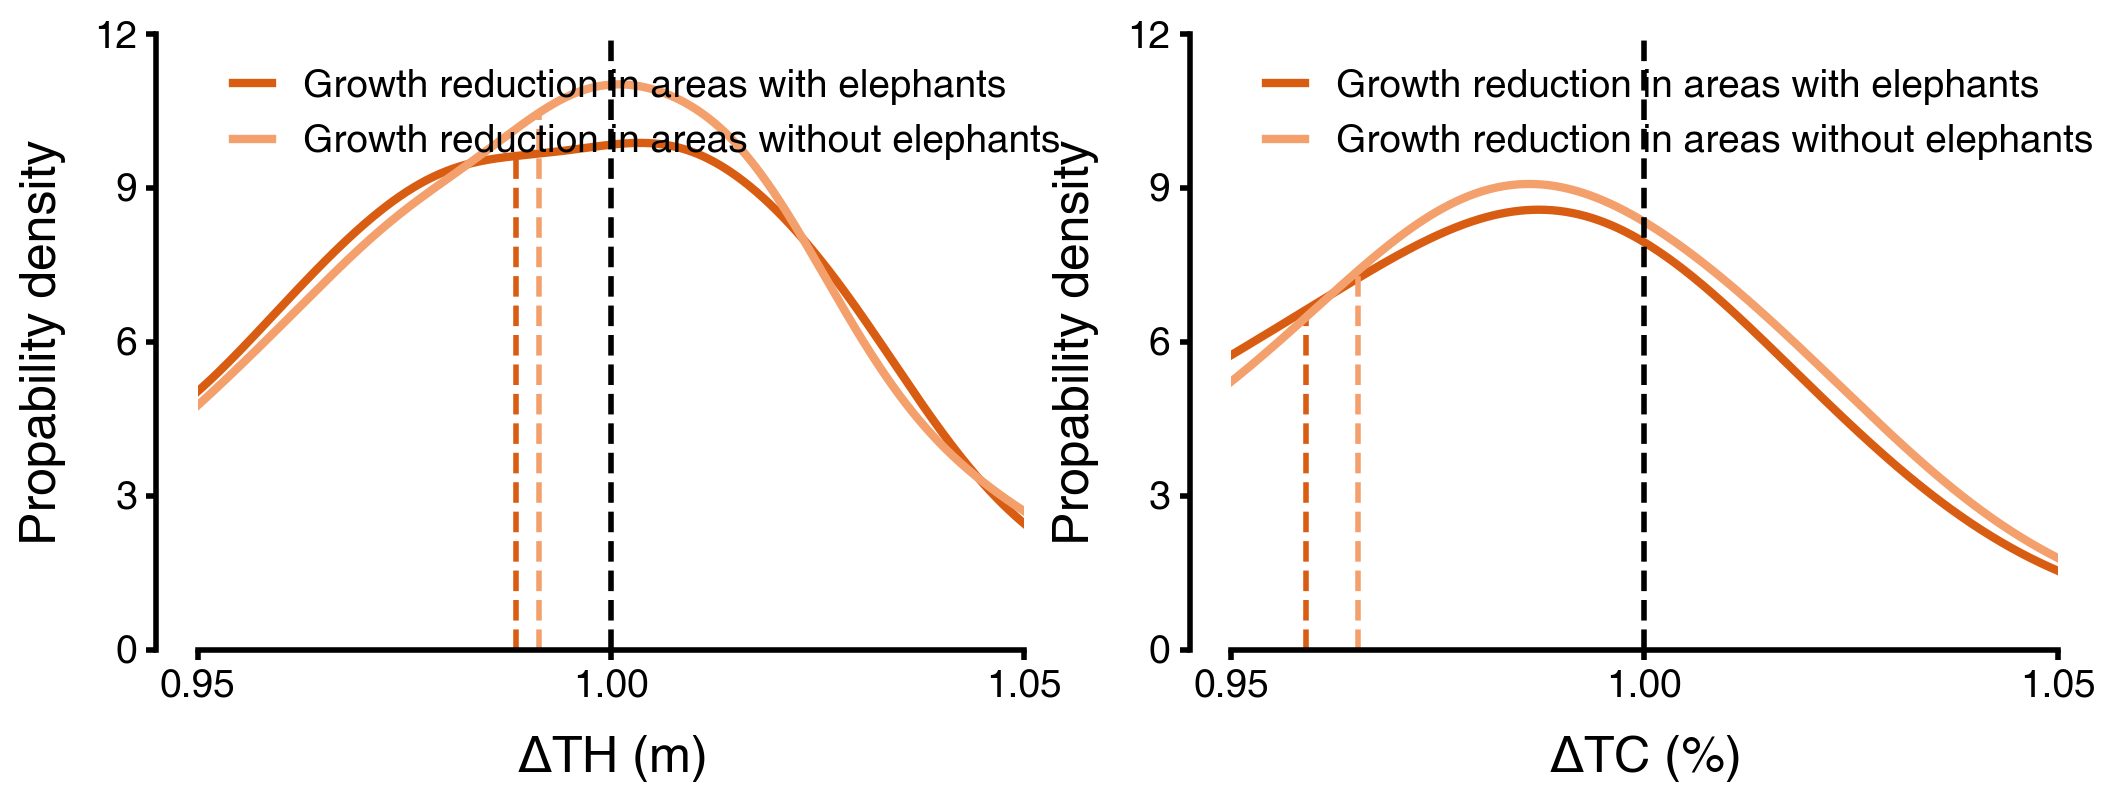

In [728]:
data_th=[res_daa[0],res_deaa[0]]
data_tc=[res_daa[1],res_deaa[1]]

data=[data_th,data_tc]
#pp=[data_pp_th,data_pp_tc]

import gloce as gc
from scipy.stats import gaussian_kde
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig = plt.figure(figsize=(12,4)) ##width, height default(8,6)
plt.subplots_adjust(wspace=0.25,hspace=0.02)
#fig.subplots_adjust(wspace=0.2,hspace=0.4, left=None, bottom=None, right=None, top=None)
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 18}
plt.rc('font', **font)  # pass in the font dict as kwargs
cl1 = np.array([(216,93,18),(243,160,109)])
cl2 = np.array([(216,93,18),(243,160,109)])
cl=[cl1/255,cl2/255]

#cl=['C0','salmon']
#colors = ['coral','yellowgreen','green','orange']
#lc3 = ['NF_BB','F_BB','F_NBB','NF_NBB']
#fig, axs=plt.subplots(2,2,sharex=True,sharey=True)
label1=['Growth reduction in areas with elephants','Growth reduction in areas without elephants']
label2=['Growth reduction in areas with elephants','Growth reduction in areas without elephants']
label=[label1,label2]
tx=['(m)','(%)']
for i in range(2):
    ax = fig.add_subplot(1,2,i+1)
    for j in range(2):
        x=np.linspace(0.9,1.1,1000)
        mean=np.nanmean(data[i][j])
        delta_rav=gc.nanravel(data[i][j])
        kenal=gaussian_kde(delta_rav)
        z=kenal.evaluate(x)
        z_mean=kenal.evaluate(mean)
        ax.plot(x,z,lw=3,color=cl[i][j],label=label[i][j])
        ax.vlines(mean,0,z_mean,lw=2,ls='--',color=cl[i][j])
    if i ==0:
        ax.vlines(1,0,12,lw=2,ls='--',color='black')
        #ax.set_ylim(0,0.3)
        #ax.set_yticks(np.arange(0,0.31,0.1))
        #ax.set_xlim(-5,5)
        #ax.set_xticks(np.arange(-5,5.1,2.5))
        ax=plt.gca()
        ax.yaxis.set_ticks_position('left')
        ax.spines['left'].set_position(('data',0.945))
        ax.set_xlabel('$\Delta$TH (m)',labelpad=10)
    else:
        ax.vlines(1,0,12,lw=2,ls='--',color='black')
        #ax.set_ylim(0,0.12)
        #ax.set_yticks(np.arange(0,0.121,0.04))
        #ax.set_xlim(-15,15)
        #ax.set_xticks(np.arange(-15,15.1,5))
        ax=plt.gca()
        ax.yaxis.set_ticks_position('left')
        ax.spines['left'].set_position(('data',0.945))
        ax.set_xlabel('$\Delta$TC (%)',labelpad=10)
    ax.legend(fontsize=14,loc='upper left',frameon=False,handlelength=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.set_xlim(0.99,1.05)
    ax.set_xticks(np.arange(0.95,1.051,0.05))
    ax.set_ylim(0,12)
    ax.set_yticks(np.arange(0,12.1,3))
    ax.set_ylabel('Propability density',labelpad=10)
    
    ax.xaxis.label.set_size(18)
    ax.xaxis.set_tick_params(width=2)

    ax.tick_params(labelsize=14)
    ax.yaxis.label.set_size(18)
    ax.yaxis.set_tick_params(width=2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
#rect = ax.patch
#rect.set_facecolor((202/255,233/255,246/255))
#fig.savefig("E:/iCloudDrive/博后工作/文章/Elephant_disturb/Fig/reviseV2/Fig2_c-d.tif", dpi=600, bbox_inches = 'tight')

# 区分LA－LC

In [743]:
LA_da=read_img(spei_path+'LA_extant_drought_001_240504.tif')[0]
LC_da=read_img(spei_path+'LC_extant_drought_001_240504.tif')[0]
print("LA_da:",LA_da.min(),LA_da.max())
print("LC_da:",LC_da.min(),LC_da.max())

LA_da[LA_da==0]=np.nan
LC_da[LC_da==0]=np.nan

LA_da: 0.0 1.0
LC_da: 0.0 1.0


In [188]:
np.count_nonzero(~np.isnan(LA_da))+np.count_nonzero(~np.isnan(LC_da))

650891

## paired sites

In [744]:
"""
2023/11/25
supply paired sites methods. 
Be notes the  suppled detail locates should be consistence with all factors.
"""
# current shape:(6500,7900)
#0.01deg to 0.25 deg window size=625 pixels
#6500/25,7900/25...(260,316)
def slide_window_mean(s,dist,res):
    #s: window size
    #dist: disturb arraya
    #res: resistance and resilience array
    mean_arr=np.zeros((260,316))
    weight_arr=np.zeros((260,316))
    loc=np.zeros((260,316)) #record the location of supplied sites
    sl=np.ones((25,25))
    for i in range(260):
        #print("sliding", i, "line...")
        for j in range(316):
            bloc_dist=dist[i*s:(i+1)*s,j*s:(j+1)*s]
            res_dist=res[i*s:(i+1)*s,j*s:(j+1)*s]
            res_mask=np.multiply(bloc_dist,res_dist)#product restance array controled by window
            count=np.count_nonzero(~np.isnan(res_mask))
            weight=count/625#calculate the weight
            if weight>0.05:
                weight_arr[i,j]=weight
                dt=np.where(res_mask!=np.nan,res_mask,np.nan)
                mean_arr[i,j]=np.nanmean(res_mask)#calculate the mean value
                loc[i,j]=9
            else:
                bloc_dist_a=[] #should be 8 nums [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                res_dist_a=[] #should be 8 nums
                res_mask_pool=[]
                weight_pool=[]
                for m in [-1,1]:
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    bloc_dist_a.append(dist[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    res_dist_a.append(res[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                bloc_dist_a.append(dist[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                bloc_dist_a.append(dist[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                res_dist_a.append(res[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                res_dist_a.append(res[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                #the smooth order of a 9 value array is [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                for n in range(len(bloc_dist_a)): #the length is 8
                    res_mask_pool.append(np.multiply(bloc_dist_a[n],res_dist_a[n]))
                    weight_pool.append(np.count_nonzero(~np.isnan(res_mask_pool[n]))/625)#calculate the weight
                key=np.argmax(weight_pool) 
                # Key used to loc the supplied direction, the key-value consistience with [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                if weight_pool[key] > 0.05:
                    weight_arr[i,j]=weight_pool[key]
                    dt1=np.where(res_mask_pool[key]!=np.nan,res_mask_pool[key],np.nan)
                    mean_arr[i,j]=np.nanmean(dt1)#calculate the mean value
                    loc[i,j]=key+1
                else:
                    mean_arr[i,j]=np.nan#calculate the mean value
                    loc[i,j]=np.nan
    return mean_arr

dist_pool=[LA_da*mask,LC_da*mask,DAA]
res_pool=[ndvi_res,csif_res,dem,slope] #protect need conver to fraction
dist_name=['LA_da','LC_da','DAA']
res_name=['ndvi_res','csif_res','dem','slope']
# protect 最后直接加上去
aa=[]
aa_name=[]
for i in range(3):
    for j in range(4):
        el=[25,dist_pool[i],res_pool[j]]
        aa.append(el)
        aa_name.append('Resistance_{}_{}_0.25deg_240504.npy'.format(dist_name[i],res_name[j]))
aa_name

['Resistance_LA_da_ndvi_res_0.25deg_240504.npy',
 'Resistance_LA_da_csif_res_0.25deg_240504.npy',
 'Resistance_LA_da_dem_0.25deg_240504.npy',
 'Resistance_LA_da_slope_0.25deg_240504.npy',
 'Resistance_LC_da_ndvi_res_0.25deg_240504.npy',
 'Resistance_LC_da_csif_res_0.25deg_240504.npy',
 'Resistance_LC_da_dem_0.25deg_240504.npy',
 'Resistance_LC_da_slope_0.25deg_240504.npy',
 'Resistance_DAA_ndvi_res_0.25deg_240504.npy',
 'Resistance_DAA_csif_res_0.25deg_240504.npy',
 'Resistance_DAA_dem_0.25deg_240504.npy',
 'Resistance_DAA_slope_0.25deg_240504.npy']

In [747]:
for i in range(12):
    print('执行任务%s (%s)...' % (i, os.getpid()))
    kk=slide_window_mean(aa[i][0],aa[i][1],aa[i][2])
    np.save(spei_path+aa_name[i],kk)

执行任务0 (53604)...
执行任务1 (53604)...
执行任务2 (53604)...
执行任务3 (53604)...
执行任务4 (53604)...
执行任务5 (53604)...
执行任务6 (53604)...
执行任务7 (53604)...
执行任务8 (53604)...
执行任务9 (53604)...
执行任务10 (53604)...
执行任务11 (53604)...


## 成对样点求Δ

In [797]:
res_name=['ndvi_res','csif_res']
######################mask DEM and Slope############################
# check the Δ dem and Δ slope distribution
#------------LA-------------------
dem1=np.load(spei_path+'Resistance_LA_da_dem_0.25deg_240504.npy',allow_pickle=True)
dem2=np.load(spei_path+'Resistance_DAA_dem_0.25deg_240504.npy',allow_pickle=True)
dem_differ=dem1-dem2

slo1=np.load(spei_path+'Resistance_LA_da_slope_0.25deg_240504.npy',allow_pickle=True)
slo2=np.load(spei_path+'Resistance_DAA_slope_0.25deg_240504.npy',allow_pickle=True)
slo_differ=slo1-slo2

dem_differ[dem_differ<-200]=np.nan
dem_differ[dem_differ>200]=np.nan
dem_differ[~np.isnan(dem_differ)]=1
slo_differ[slo_differ<-10]=np.nan
slo_differ[slo_differ>10]=np.nan
slo_differ[~np.isnan(slo_differ)]=1
# 每一层数据位置对应,建立mask
dd_mask_LA=np.ones((260,316))*dem_differ*slo_differ
#------------------LC--------------------
dem1=np.load(spei_path+'Resistance_LC_da_dem_0.25deg_240504.npy',allow_pickle=True)
dem2=np.load(spei_path+'Resistance_DAA_dem_0.25deg_240504.npy',allow_pickle=True)
dem_differ=dem1-dem2

slo1=np.load(spei_path+'Resistance_LC_da_slope_0.25deg_240504.npy',allow_pickle=True)
slo2=np.load(spei_path+'Resistance_DAA_slope_0.25deg_240504.npy',allow_pickle=True)
slo_differ=slo1-slo2

dem_differ[dem_differ<-200]=np.nan
dem_differ[dem_differ>200]=np.nan
dem_differ[~np.isnan(dem_differ)]=1
slo_differ[slo_differ<-10]=np.nan
slo_differ[slo_differ>10]=np.nan
slo_differ[~np.isnan(slo_differ)]=1
# 每一层数据位置对应,建立mask
dd_mask_LC=np.ones((260,316))*dem_differ*slo_differ

delta_LA=[]
d_DAA_LA=[]
for i in range(2):
    f1=np.load(spei_path+'Resistance_LA_da_{}_0.25deg_240504.npy'.format(res_name[i]),allow_pickle=True)*dd_mask_LA
    f2=np.load(spei_path+'Resistance_DAA_{}_0.25deg_240504.npy'.format(res_name[i]),allow_pickle=True)*dd_mask_LA
    ff=f1-f2
    delta_LA.append(ff)
    d_DAA_LA.append(f2)
    
delta_LC=[]
d_DAA_LC=[]
for i in range(2):
    f1=np.load(spei_path+'Resistance_LC_da_{}_0.25deg_240504.npy'.format(res_name[i]),allow_pickle=True)*dd_mask_LC
    f2=np.load(spei_path+'Resistance_DAA_{}_0.25deg_240504.npy'.format(res_name[i]),allow_pickle=True)*dd_mask_LC
    ff=f1-f2
    delta_LC.append(ff)
    d_DAA_LC.append(f2)
delta_LA[0].shape

(260, 316)

In [798]:
for i in range(2):
    print(res_name[i],"LA count is",np.count_nonzero(~np.isnan(delta_LA[i])))
for i in range(2):
    print(res_name[i],"LC count is",np.count_nonzero(~np.isnan(delta_LC[i])))

ndvi_res LA count is 1789
csif_res LA count is 1790
ndvi_res LC count is 1154
csif_res LC count is 1154


In [799]:
def kill_nan(dt):
    a=dt.ravel()
    a=a[~np.isnan(a)]
    a=list(a)
    return a
#----所有格点---
resLA_delta=[]
resLC_delta=[]
#----植被下降格点---
resLA_delta_a=[]
mm_LA=[]
resLC_delta_a=[]
mm_LC=[]
for i in range(2):
    #所有格点
    resLA_delta.append(kill_nan(delta_LA[i]))
    resLC_delta.append(kill_nan(delta_LC[i]))
    #植被下降格点
    tt_LA=np.copy(d_DAA_LA[i])
    tt_LA[tt_LA>1]=np.nan
    tt_LA[tt_LA<=1]=1
    mm_LA.append(tt_LA)
    resLA_delta_a.append(kill_nan(delta_LA[i]*tt_LA))
    tt_LC=np.copy(d_DAA_LC[i])
    tt_LC[tt_LC>1]=np.nan
    tt_LC[tt_LC<=1]=1
    mm_LC.append(tt_LC)
    resLC_delta_a.append(kill_nan(delta_LC[i]*tt_LC))

In [800]:
#所有格点data
resLA_delta=list(map(list, zip(*resLA_delta)))#list转置
resLC_delta=list(map(list, zip(*resLC_delta)))#list转置
df_resLA_delta=pd.DataFrame(resLA_delta,columns=['ndvi_res','csif_res'])
df_resLC_delta=pd.DataFrame(resLC_delta,columns=['ndvi_res','csif_res'])
df_resLA_delta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1789 entries, 0 to 1788
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ndvi_res  1789 non-null   float64
 1   csif_res  1789 non-null   float64
dtypes: float64(2)
memory usage: 28.1 KB


In [801]:
#植被下降格点data
resLA_delta_a=list(map(list, zip(*resLA_delta_a)))#list转置
resLC_delta_a=list(map(list, zip(*resLC_delta_a)))#list转置
df_resLA_delta_a=pd.DataFrame(resLA_delta_a,columns=['ndvi_res','csif_res'])
df_resLC_delta_a=pd.DataFrame(resLC_delta_a,columns=['ndvi_res','csif_res'])
df_resLA_delta_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1239 entries, 0 to 1238
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ndvi_res  1239 non-null   float64
 1   csif_res  1239 non-null   float64
dtypes: float64(2)
memory usage: 19.5 KB


In [814]:
df_resLC_delta_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507 entries, 0 to 506
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ndvi_res  507 non-null    float64
 1   csif_res  507 non-null    float64
dtypes: float64(2)
memory usage: 8.0 KB


In [802]:
#所有格点统计
print(np.std(df_resLA_delta['ndvi_res']),np.std(df_resLA_delta['csif_res']))
print(np.std(df_resLC_delta['ndvi_res']),np.std(df_resLC_delta['csif_res']))
print(stats.sem(df_resLA_delta['ndvi_res']),stats.sem(df_resLA_delta['csif_res']))
print(stats.sem(df_resLC_delta['ndvi_res']),stats.sem(df_resLC_delta['csif_res']))
print(np.mean(df_resLA_delta['ndvi_res']),np.mean(df_resLA_delta['csif_res']))
print(np.mean(df_resLC_delta['ndvi_res']),np.mean(df_resLC_delta['csif_res']))

0.03438754439775536 0.07595414149725041
0.03130465486813987 0.031815477014185585
0.0008132375192402265 0.001796253809018041
0.0009219221861257621 0.0009369658999628127
0.003303899553116638 0.005050161885708787
0.0016661665468529977 0.003855559555248743


In [803]:
#植被下降格点统计
print(np.std(df_resLA_delta_a['ndvi_res']),np.std(df_resLA_delta_a['csif_res']))
print(np.std(df_resLC_delta_a['ndvi_res']),np.std(df_resLC_delta_a['csif_res']))
print(stats.sem(df_resLA_delta_a['ndvi_res']),stats.sem(df_resLA_delta_a['csif_res']))
print(stats.sem(df_resLC_delta_a['ndvi_res']),stats.sem(df_resLC_delta_a['csif_res']))
print(np.mean(df_resLA_delta_a['ndvi_res']),np.mean(df_resLA_delta_a['csif_res']))
print(np.mean(df_resLC_delta_a['ndvi_res']),np.mean(df_resLC_delta_a['csif_res']))

0.03402643674607558 0.0689471195371864
0.029485274614301928 0.037957645780020886
0.0009670660780845387 0.0019595475419195286
0.0013107803389575327 0.0016874231782610678
0.009908642616841561 0.017964842436869747
0.007081459142282399 0.008947226187651444


## significants

In [804]:
def del_nan(data,data1):
    aa=np.where(np.isnan(data.ravel()))
    bb=np.where(np.isnan(data1.ravel()))
    kk=np.concatenate((aa,bb),axis=1)
    yy=np.unique(kk)
    data=np.delete(data.ravel(),yy)
    data1=np.delete(data1.ravel(),yy)
    return data, data1

p_delta_LA=[]
for i in range(2):
    f1=np.load(spei_path+'Resistance_LA_da_{}_0.25deg_240504.npy'.format(res_name[i]),allow_pickle=True)*dd_mask_LA
    f2=np.load(spei_path+'Resistance_DAA_{}_0.25deg_240504.npy'.format(res_name[i]),allow_pickle=True)*dd_mask_LA
    ddt=del_nan(f1,f2)
    sta,p=stats.wilcoxon(ddt[0],ddt[1])
    p_delta_LA.append(p)

In [805]:
p_delta_LC=[]
for i in range(2):
    f1=np.load(spei_path+'Resistance_LC_da_{}_0.25deg_240504.npy'.format(res_name[i]),allow_pickle=True)*dd_mask_LC
    f2=np.load(spei_path+'Resistance_DAA_{}_0.25deg_240504.npy'.format(res_name[i]),allow_pickle=True)*dd_mask_LC
    ddt=del_nan(f1,f2)
    sta,p=stats.wilcoxon(ddt[0],ddt[1])
    p_delta_LC.append(p)

p_delta_LA,p_delta_LC #p value of ndvi_res and csif_res

([6.763459363453116e-05, 3.9181930582574544e-05],
 [0.03731897787571622, 0.00572996877161338])

## fig

In [806]:
dd_delta_ndvi=[df_resLA_delta['ndvi_res'],df_resLC_delta['ndvi_res']]
dd_delta_csif=[df_resLA_delta['csif_res'],df_resLC_delta['csif_res']]
dd_delta=[dd_delta_ndvi,dd_delta_csif]

pp=[[p_delta_LA[0],p_delta_LC[0]],#LA_ndvi,LC_ndvi
    [p_delta_LA[1],p_delta_LC[1]]]#LA_sif,LC_sif

0.003303899553116638 [14.39169994]
0.0016661665468529977 [18.00144374]
0.005050161885708787 [8.65545481]
0.003855559555248743 [15.64101362]


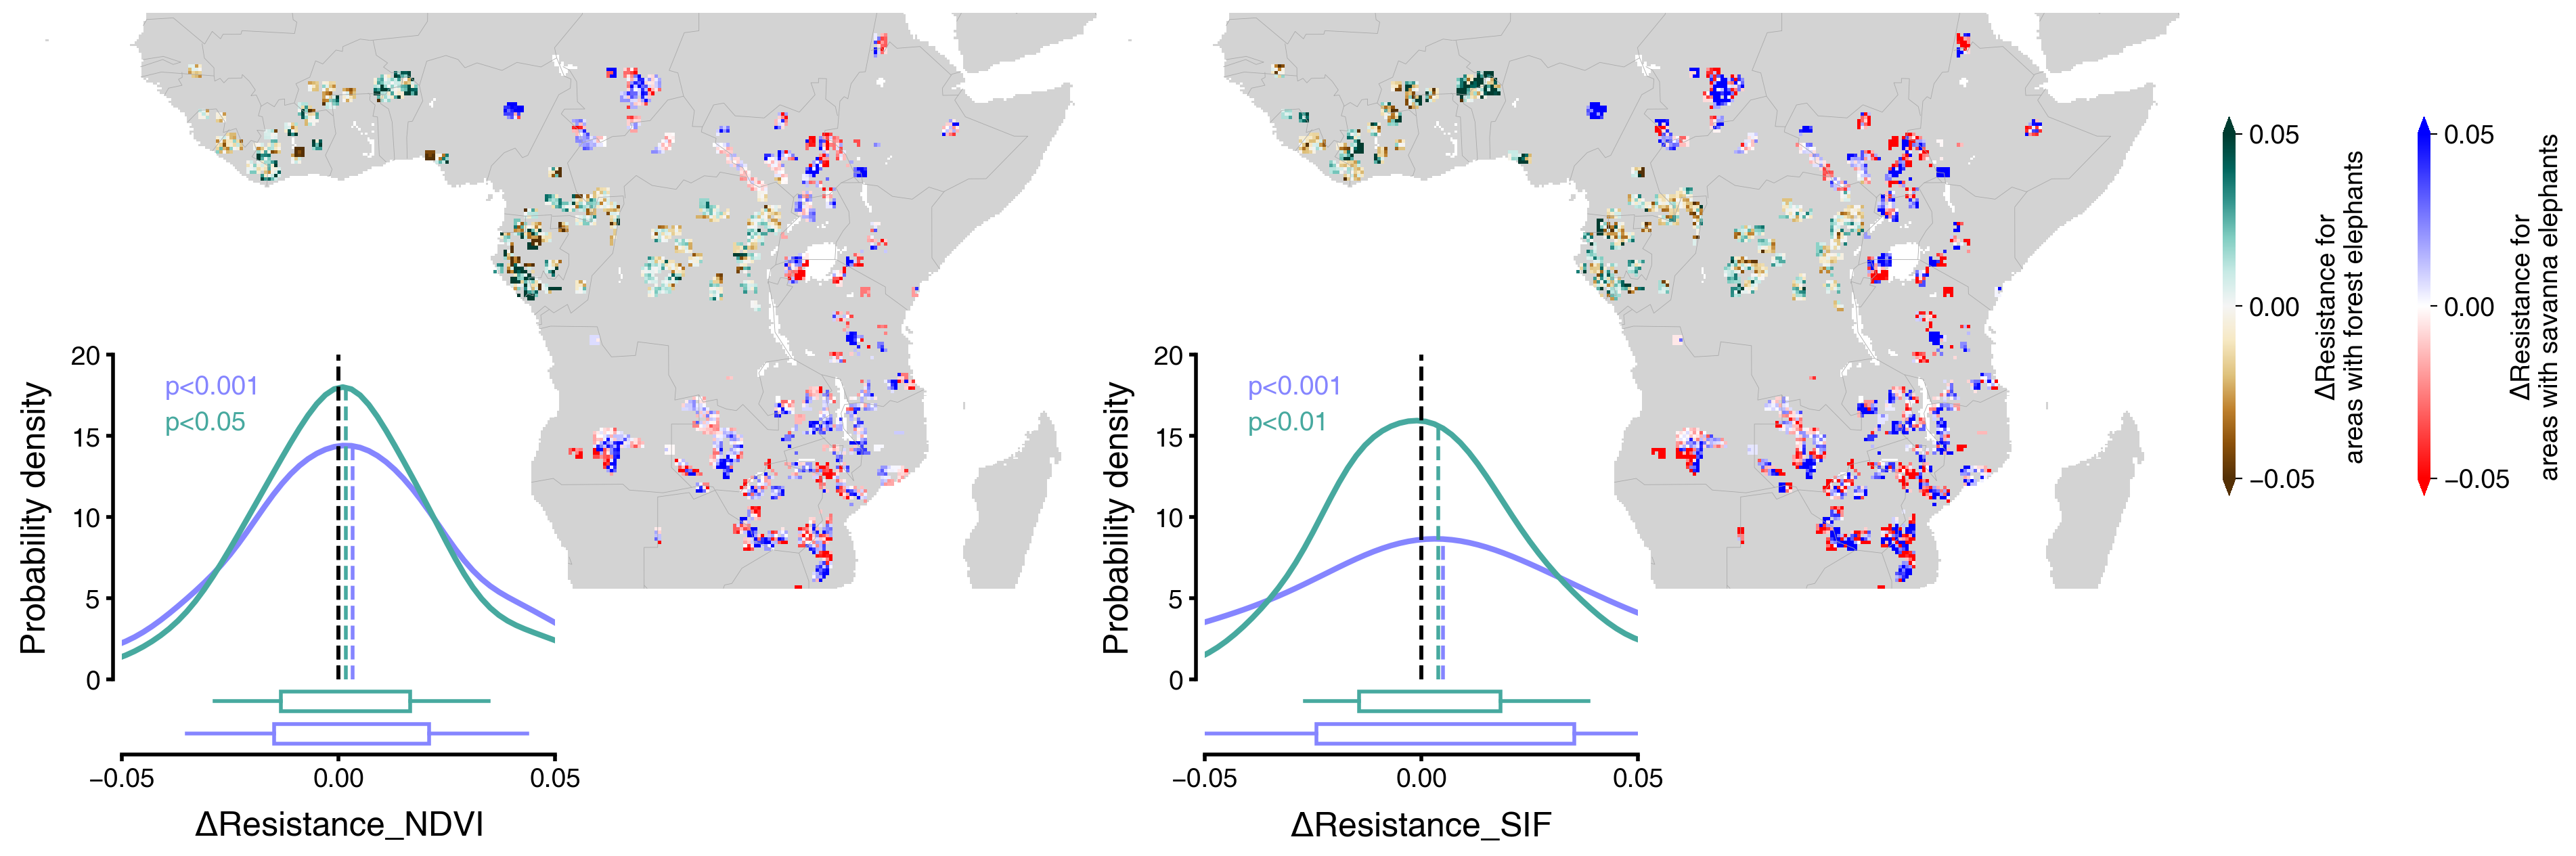

In [807]:
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 14}
#fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(16,12), sharex=False,sharey=False)
#return im_data, im_width, im_height, im_geotrans, im_proj
#(-25.37, 37.36, 51.42, -46.980000000000004)
#(-26.0, 25.0, 53.0, -40.0)
lon1 = -26
lon2 = 53
lat1 = -25
lat2 = 17

left, bottom, width, hegiht= 0, 0, 0.5,1
left1, bottom1, width1, hegiht1= 0.5, 0, 0.5,1
loc=[[left, bottom, width, hegiht],[left1, bottom1, width1, hegiht1]]
left2, bottom2, width2, hegiht2= 0.05, 0.15, 0.2,0.3
left3, bottom3, width3, hegiht3= 0.55, 0.15, 0.2,0.3
loc1=[[left2, bottom2, width2, hegiht2],[left3, bottom3, width3, hegiht3]]

LA_ndvi_delta=delta_LA[0][32:200]
LA_csif_delta=delta_LA[1][32:200]
LC_ndvi_delta=delta_LC[0][32:200]
LC_csif_delta=delta_LC[1][32:200]

LA_data=[LA_ndvi_delta,LA_csif_delta]
LC_data=[LC_ndvi_delta,LC_csif_delta]

cl= np.array([(112,173,71),(169,209,142)])
cl1 = np.array([(251,153,143),(248,203,173)])
cl=cl/255
cl1=cl1/255
cl2=np.array([(133,133,255),(71,169,159)])
cl2=cl2/255
res_name=['ndvi_res','csif_res']

fig = plt.figure(figsize=(16,8)) ##width, height default(8,6)
label=['$\Delta$Resistance for\nareas with savanna elephants','$\Delta$Resistance for\nareas with forest elephants']
text=['a','b']
for i in range(2):
    ax = fig.add_subplot(loc[i])
    m = Basemap(llcrnrlon=lon1,llcrnrlat=lat1,urcrnrlon=lon2,urcrnrlat=lat2,ax=ax)
    m.drawlsmask(land_color='lightgray',ocean_color='none',lakes=True)
    m.drawcountries(linewidth=0.30, color='darkgrey')
    #m.drawmapboundary(fill_color='skyblue')
    #m.drawcoastlines(linewidth=0.50, color='black',zorder=40)
    norm = mcolors.TwoSlopeNorm(vmin=-0.05, vmax = 0.05, vcenter=0)
    im = m.imshow(LA_data[i],cmap ='bwr_r',origin='upper',norm=norm)
    im1 = m.imshow(LC_data[i],cmap ='BrBG',origin='upper',norm=norm)
    #remove the broder of figure
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    #ax.text(0.01,0.9-i*0.008, text[i], transform = ax.transAxes,color='black',fontsize=18)
    if i ==1:
        #position=fig.add_axes([0.15])
        #position=fig.add_axes([0.35,0.08,0.15,0.01])#左、底、宽、高
        #position1=fig.add_axes([0.53,0.08,0.15,0.01])#左、底、宽、高
        position1=fig.add_axes([1.02,0.32,0.006,0.35])#左、底、宽、高
        position=fig.add_axes([1.11,0.32,0.006,0.35])#左、底、宽、高
        cb=fig.colorbar(im,ax=ax,extend='both',shrink=0.3,pad=0.01,cax=position)#orientation='horizontal',
        cb.set_label(label[0],fontsize=14,labelpad=0)
        cb.set_ticks(np.arange(-0.05,0.051,0.05)) 
        cb.ax.tick_params(labelsize=14)
        cb.outline.set_visible(False)
        cb1=fig.colorbar(im1,ax=ax,extend='both',shrink=0.3,pad=0.01,cax=position1)
        cb1.set_label(label[1],fontsize=14,labelpad=0)
        cb1.set_ticks(np.arange(-0.05,0.051,0.05)) 
        cb1.ax.tick_params(labelsize=14)
        cb1.outline.set_visible(False)
#--------------------------------------添加 子图， pdf----------------------------------------------#
for i in range(2):
    ax1 = fig.add_subplot(loc1[i])
    for j in range(2):
        x=np.linspace(-1,1,1000)
        mean=np.nanmean(dd_delta[i][j])
        delta_rav=gc.nanravel(dd_delta[i][j])
        kenal=gaussian_kde(delta_rav)
        z=kenal.evaluate(x)
        z_mean=kenal.evaluate(mean)
        print(mean,z_mean)
        #label=['LA-NDVI'' {:.3f} ***'.format(mean),'LA-CSIF'' {:.3f} ***'.format(mean)]
        ax1.plot(x,z,lw=3,color=cl2[j])#,label=label_a[i][j]
        ax1.vlines(mean,0,z_mean,lw=2,ls='--',color=cl2[j])
        ax1.vlines(0,0,20,lw=2,ls='--',color='black')
        ax1.spines['right'].set_visible(False)
        ax1.spines['top'].set_visible(False)
        #ax1.spines['bottom'].set_visible(False)
        if pp[i][j]<0.001:
            ax1.text(0.1,0.88-j*0.11, 'p<0.001', fontsize=14,transform = ax1.transAxes,color=cl2[j])
        elif pp[i][j]<0.01:
            ax1.text(0.1,0.88-j*0.11, 'p<0.01', fontsize=14,transform = ax1.transAxes,color=cl2[j])
        elif pp[i][j]<0.05:
            ax1.text(0.1,0.88-j*0.11, 'p<0.05', fontsize=14,transform = ax1.transAxes,color=cl2[j])
        else:
            ax1.text(0.1,0.88-j*0.11, 'p={:.3f}'.format(pp[i][j]), fontsize=14,transform = ax1.transAxes,color=cl2[j])
        #ax1.legend(fontsize=14,loc='upper left',frameon=False)
    if i ==0:
        ax1.set_xlabel('$\Delta$Resistance_NDVI',labelpad=10)
    else:
        ax1.set_xlabel('$\Delta$Resistance_SIF',labelpad=10)
    #ax.text(-0.15,1, '(c)', transform = ax.transAxes,color='black',fontsize=20)
    ax1=plt.gca()
    ax1.yaxis.set_ticks_position('left')
    ax1.spines['left'].set_position(('data',-0.052))
    ax1.xaxis.set_ticks_position('bottom')
    ax1.spines['bottom'].set_position(('data',-4.6))
    ax1.set_ylim(0,20)
    ax1.set_xlim(-0.05,0.05)
    ax1.set_xticks(np.arange(-0.05,0.051,0.05))
    ax1.set_yticks(np.arange(0,20.1,5))
    ax1.set_ylabel('Probability density',labelpad=10)
    
    ax1.tick_params(labelsize=14)
    ax1.xaxis.label.set_size(18)
    ax1.yaxis.label.set_size(18)
    ax1.xaxis.set_tick_params(width=2)
    ax1.yaxis.set_tick_params(width=2)
    ax1.spines['left'].set_linewidth(2)
    ax1.spines['bottom'].set_linewidth(2)
    ax1.set(facecolor='none')
    #----------箱线图---------------------
    for j in range(2):
        if i ==0:
            if j ==0:
                ax2=fig.add_axes([0.05,0.07,0.2,0.06])#左，底，宽，高
            else:
                ax2=fig.add_axes([0.05,0.1,0.2,0.06])#左，底，宽，高
        else:
            if j==0:
                ax2=fig.add_axes([0.55,0.07,0.2,0.06])#左，底，宽，高
            else:
                ax2=fig.add_axes([0.55,0.1,0.2,0.06])#左，底，宽，高
        ax2.set_xlim(-0.05,0.05)
        ax2.set_xticks(np.arange(-0.05,0.051,0.05))
        ax2.axis('off')
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.tick_params(bottom=True,top=False, left=False, right=False)#隐藏刻度线
        ax2.spines['bottom'].set_visible(True)
        bplot=ax2.boxplot(dd_delta[i][j],
                          vert=False,
                          whis=(10,90),                
                          widths=0.3,
                          patch_artist=True,
                          showmeans=False,
                          meanprops = {'marker':'o','markerfacecolor':cl2[j],"markeredgecolor":cl2[j],"markersize":15,"alpha":0}, # 设置均值点的属性，点的形状、填充色
                          medianprops={'linewidth':'0.5',"color":cl2[j],"alpha":0},
                          boxprops={"facecolor": 'none', "edgecolor": cl2[j],"linewidth":2,"alpha":1},
                          capprops=None,
                          whiskerprops={'linewidth':'2','color':cl2[j]},
                          showcaps=False,# 是否显示箱线图顶端和末端的两条线，默认显示
                          showfliers = False,
                          flierprops = {'marker':'+','markersize':'3','markeredgecolor':cl2[j],'color':cl2[j]})
        ax2.set(facecolor='none')

#fig.savefig("E:/iCloudDrive/博后工作/文章/Elephant_disturb/Fig/reviseV2/FigS2_resistance patterns_LA-LC_240116.tif", dpi=600, bbox_inches = 'tight')

## 植被下降区域

In [808]:
def del_nan(data,data1):
    aa=np.where(np.isnan(data.ravel()))
    bb=np.where(np.isnan(data1.ravel()))
    kk=np.concatenate((aa,bb),axis=1)
    yy=np.unique(kk)
    data=np.delete(data.ravel(),yy)
    data1=np.delete(data1.ravel(),yy)
    return data, data1

p_delta_LA_a=[]
for i in range(2):
    f1=np.load(spei_path+'Resistance_LA_da_{}_0.25deg_240504.npy'.format(res_name[i]),allow_pickle=True)*dd_mask_LA
    f2=np.load(spei_path+'Resistance_DAA_{}_0.25deg_240504.npy'.format(res_name[i]),allow_pickle=True)*dd_mask_LA
    ddt=del_nan(f1*mm_LA[i],f2*mm_LA[i])
    sta,p=stats.wilcoxon(ddt[0],ddt[1])
    p_delta_LA_a.append(p)
p_delta_LA_a

[4.299490946957656e-23, 6.475724277493943e-23]

In [809]:
p_delta_LC_a=[]
for i in range(2):
    f1=np.load(spei_path+'Resistance_LC_da_{}_0.25deg_240504.npy'.format(res_name[i]),allow_pickle=True)*dd_mask_LC
    f2=np.load(spei_path+'Resistance_DAA_{}_0.25deg_240504.npy'.format(res_name[i]),allow_pickle=True)*dd_mask_LC
    ddt=del_nan(f1*mm_LC[i],f2*mm_LC[i])
    sta,p=stats.wilcoxon(ddt[0],ddt[1])
    p_delta_LC_a.append(p)

p_delta_LA_a,p_delta_LC_a #p value of ndvi_res and csif_res

([4.299490946957656e-23, 6.475724277493943e-23],
 [1.436212401596696e-10, 7.1615729088782525e-12])

In [810]:
dd_delta_ndvi_a=[df_resLA_delta_a['ndvi_res'],df_resLC_delta_a['ndvi_res']]
dd_delta_csif_a=[df_resLA_delta_a['csif_res'],df_resLC_delta_a['csif_res']]
dd_delta_a=[dd_delta_ndvi_a,dd_delta_csif_a]

pp=[[p_delta_LA_a[0],p_delta_LC_a[0]],#LA_ndvi,LC_ndvi
    [p_delta_LA_a[1],p_delta_LC_a[1]]]#LA_sif,LC_sif

0.009908642616841561 [13.9491774]
0.007081459142282399 [17.44075788]
0.017964842436869747 [8.25158715]
0.008947226187651444 [12.15153588]


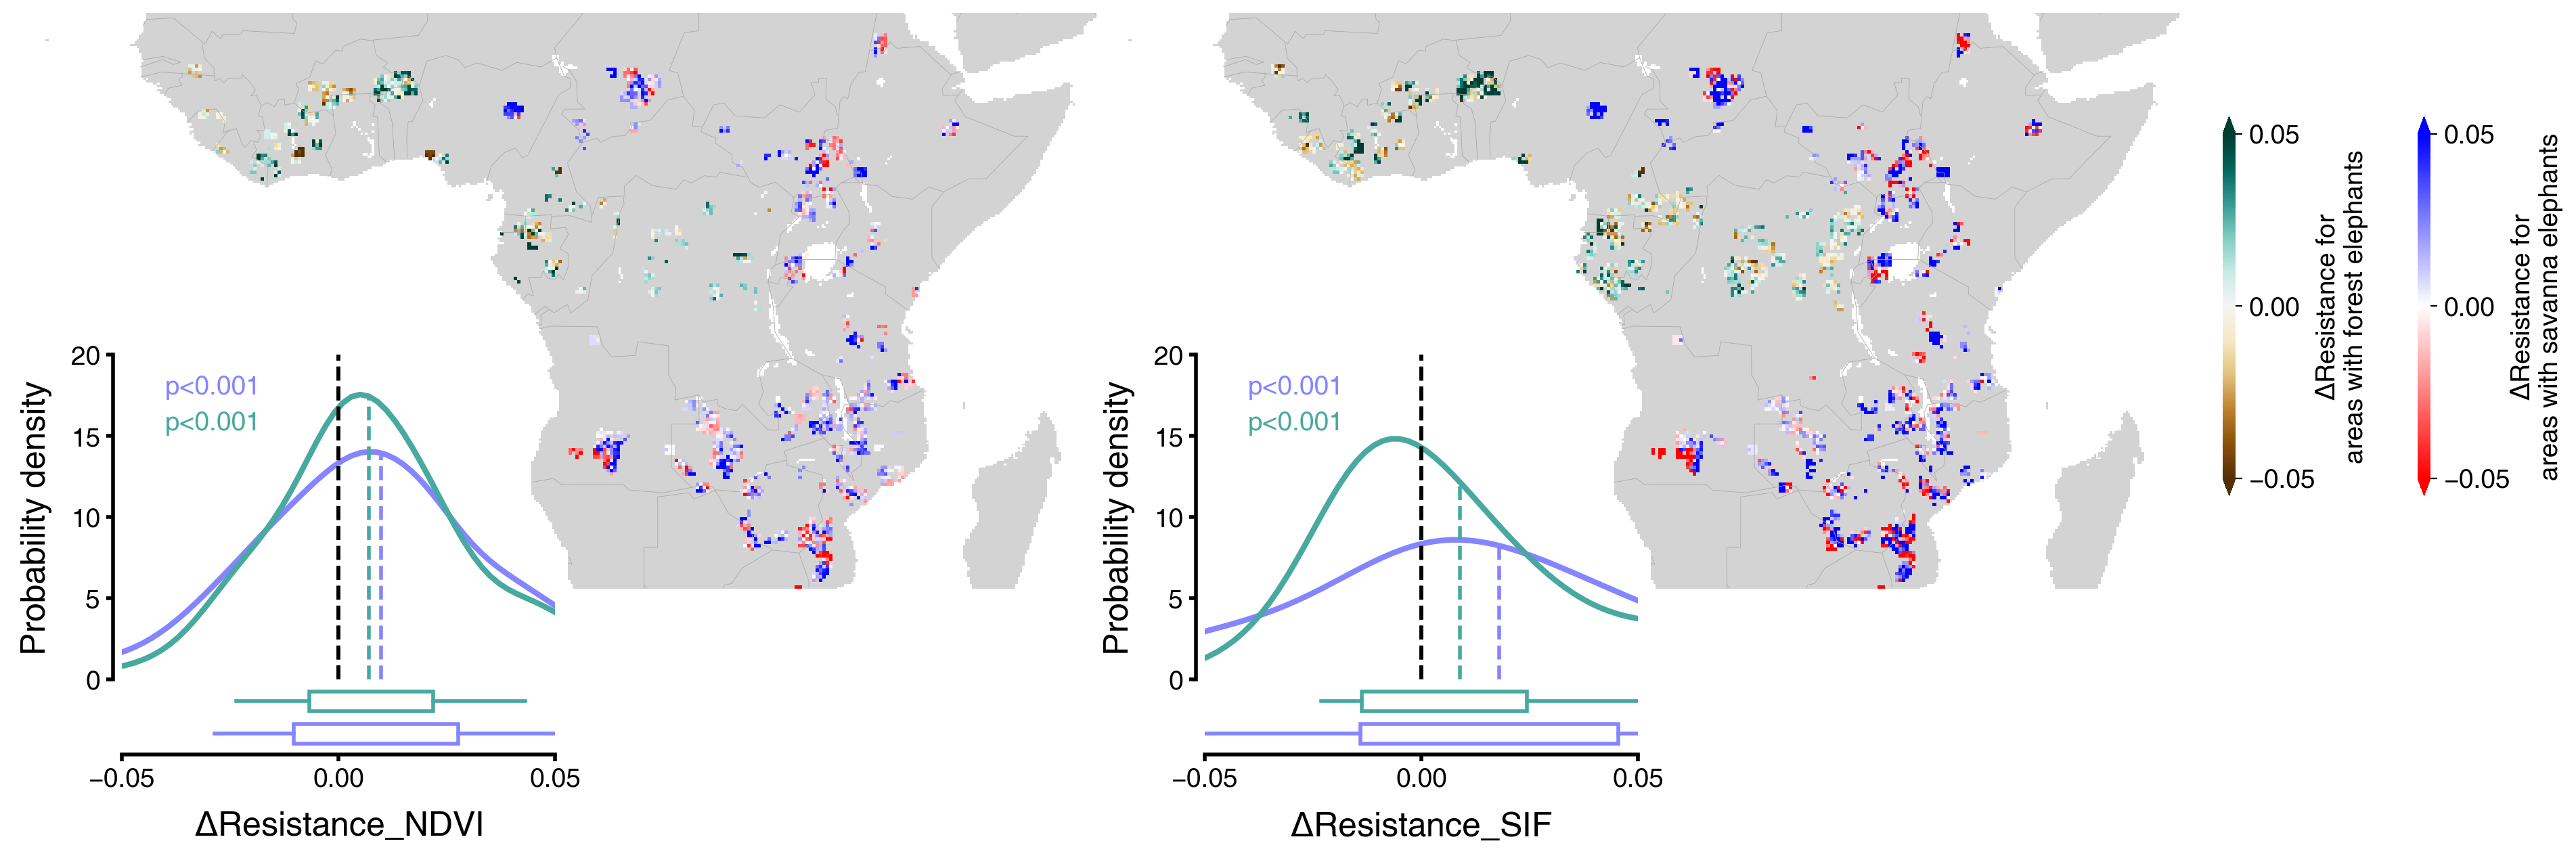

In [811]:
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 14}
#fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(16,12), sharex=False,sharey=False)
#return im_data, im_width, im_height, im_geotrans, im_proj
#(-25.37, 37.36, 51.42, -46.980000000000004)
#(-26.0, 25.0, 53.0, -40.0)
lon1 = -26
lon2 = 53
lat1 = -25
lat2 = 17

left, bottom, width, hegiht= 0, 0, 0.5,1
left1, bottom1, width1, hegiht1= 0.5, 0, 0.5,1
loc=[[left, bottom, width, hegiht],[left1, bottom1, width1, hegiht1]]
left2, bottom2, width2, hegiht2= 0.05, 0.15, 0.2,0.3
left3, bottom3, width3, hegiht3= 0.55, 0.15, 0.2,0.3
loc1=[[left2, bottom2, width2, hegiht2],[left3, bottom3, width3, hegiht3]]

LA_ndvi_delta=np.array(delta_LA[0]*mm_LA[0])[32:200]
LA_csif_delta=np.array(delta_LA[1]*mm_LA[1])[32:200]
LC_ndvi_delta=np.array(delta_LC[0]*mm_LC[0])[32:200]
LC_csif_delta=np.array(delta_LC[1]*mm_LC[1])[32:200]

LA_data=[LA_ndvi_delta,LA_csif_delta]
LC_data=[LC_ndvi_delta,LC_csif_delta]

cl= np.array([(112,173,71),(169,209,142)])
cl1 = np.array([(251,153,143),(248,203,173)])
cl=cl/255
cl1=cl1/255
cl2=np.array([(133,133,255),(71,169,159)])
cl2=cl2/255
res_name=['ndvi_res','csif_res']

fig = plt.figure(figsize=(16,8)) ##width, height default(8,6)
label=['$\Delta$Resistance for\nareas with savanna elephants','$\Delta$Resistance for\nareas with forest elephants']
text=['a','b']
for i in range(2):
    ax = fig.add_subplot(loc[i])
    m = Basemap(llcrnrlon=lon1,llcrnrlat=lat1,urcrnrlon=lon2,urcrnrlat=lat2,ax=ax)
    m.drawlsmask(land_color='lightgray',ocean_color='none',lakes=True)
    m.drawcountries(linewidth=0.30, color='darkgrey')
    #m.drawmapboundary(fill_color='skyblue')
    #m.drawcoastlines(linewidth=0.50, color='black',zorder=40)
    norm = mcolors.TwoSlopeNorm(vmin=-0.05, vmax = 0.05, vcenter=0)
    im = m.imshow(LA_data[i],cmap ='bwr_r',origin='upper',norm=norm)
    im1 = m.imshow(LC_data[i],cmap ='BrBG',origin='upper',norm=norm)
    #remove the broder of figure
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    #ax.text(0.01,0.9-i*0.008, text[i], transform = ax.transAxes,color='black',fontsize=18)
    if i ==1:
        #position=fig.add_axes([0.15])
        #position=fig.add_axes([0.35,0.08,0.15,0.01])#左、底、宽、高
        #position1=fig.add_axes([0.53,0.08,0.15,0.01])#左、底、宽、高
        position1=fig.add_axes([1.02,0.32,0.006,0.35])#左、底、宽、高
        position=fig.add_axes([1.11,0.32,0.006,0.35])#左、底、宽、高
        cb=fig.colorbar(im,ax=ax,extend='both',shrink=0.3,pad=0.01,cax=position)#orientation='horizontal',
        cb.set_label(label[0],fontsize=14,labelpad=0)
        cb.set_ticks(np.arange(-0.05,0.051,0.05)) 
        cb.ax.tick_params(labelsize=14)
        cb.outline.set_visible(False)
        cb1=fig.colorbar(im1,ax=ax,extend='both',shrink=0.3,pad=0.01,cax=position1)
        cb1.set_label(label[1],fontsize=14,labelpad=0)
        cb1.set_ticks(np.arange(-0.05,0.051,0.05)) 
        cb1.ax.tick_params(labelsize=14)
        cb1.outline.set_visible(False)
#--------------------------------------添加 子图， pdf----------------------------------------------#
for i in range(2):
    ax1 = fig.add_subplot(loc1[i])
    for j in range(2):
        x=np.linspace(-1,1,1000)
        mean=np.nanmean(dd_delta_a[i][j])
        delta_rav=gc.nanravel(dd_delta_a[i][j])
        kenal=gaussian_kde(delta_rav)
        z=kenal.evaluate(x)
        z_mean=kenal.evaluate(mean)
        print(mean,z_mean)
        #label=['LA-NDVI'' {:.3f} ***'.format(mean),'LA-CSIF'' {:.3f} ***'.format(mean)]
        ax1.plot(x,z,lw=3,color=cl2[j])#,label=label_a[i][j]
        ax1.vlines(mean,0,z_mean,lw=2,ls='--',color=cl2[j])
        ax1.vlines(0,0,20,lw=2,ls='--',color='black')
        ax1.spines['right'].set_visible(False)
        ax1.spines['top'].set_visible(False)
        #ax1.spines['bottom'].set_visible(False)
        if pp[i][j]<0.001:
            ax1.text(0.1,0.88-j*0.11, 'p<0.001', fontsize=14,transform = ax1.transAxes,color=cl2[j])
        elif pp[i][j]<0.01:
            ax1.text(0.1,0.88-j*0.11, 'p<0.01', fontsize=14,transform = ax1.transAxes,color=cl2[j])
        elif pp[i][j]<0.05:
            ax1.text(0.1,0.88-j*0.11, 'p<0.05', fontsize=14,transform = ax1.transAxes,color=cl2[j])
        else:
            ax1.text(0.1,0.88-j*0.11, 'p={:.3f}'.format(pp[i][j]), fontsize=14,transform = ax1.transAxes,color=cl2[j])
        #ax1.legend(fontsize=14,loc='upper left',frameon=False)
    if i ==0:
        ax1.set_xlabel('$\Delta$Resistance_NDVI',labelpad=10)
    else:
        ax1.set_xlabel('$\Delta$Resistance_SIF',labelpad=10)
    #ax.text(-0.15,1, '(c)', transform = ax.transAxes,color='black',fontsize=20)
    ax1=plt.gca()
    ax1.yaxis.set_ticks_position('left')
    ax1.spines['left'].set_position(('data',-0.052))
    ax1.xaxis.set_ticks_position('bottom')
    ax1.spines['bottom'].set_position(('data',-4.6))
    ax1.set_ylim(0,20)
    ax1.set_xlim(-0.05,0.05)
    ax1.set_xticks(np.arange(-0.05,0.051,0.05))
    ax1.set_yticks(np.arange(0,20.1,5))
    ax1.set_ylabel('Probability density',labelpad=10)
    
    ax1.tick_params(labelsize=14)
    ax1.xaxis.label.set_size(18)
    ax1.yaxis.label.set_size(18)
    ax1.xaxis.set_tick_params(width=2)
    ax1.yaxis.set_tick_params(width=2)
    ax1.spines['left'].set_linewidth(2)
    ax1.spines['bottom'].set_linewidth(2)
    ax1.set(facecolor='none')
    #----------箱线图---------------------
    for j in range(2):
        if i ==0:
            if j ==0:
                ax2=fig.add_axes([0.05,0.07,0.2,0.06])#左，底，宽，高
            else:
                ax2=fig.add_axes([0.05,0.1,0.2,0.06])#左，底，宽，高
        else:
            if j==0:
                ax2=fig.add_axes([0.55,0.07,0.2,0.06])#左，底，宽，高
            else:
                ax2=fig.add_axes([0.55,0.1,0.2,0.06])#左，底，宽，高
        ax2.set_xlim(-0.05,0.05)
        ax2.set_xticks(np.arange(-0.05,0.051,0.05))
        ax2.axis('off')
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.tick_params(bottom=True,top=False, left=False, right=False)#隐藏刻度线
        ax2.spines['bottom'].set_visible(True)
        bplot=ax2.boxplot(dd_delta_a[i][j],
                          vert=False,
                          whis=(10,90),                
                          widths=0.3,
                          patch_artist=True,
                          showmeans=False,
                          meanprops = {'marker':'o','markerfacecolor':cl2[j],"markeredgecolor":cl2[j],"markersize":15,"alpha":0}, # 设置均值点的属性，点的形状、填充色
                          medianprops={'linewidth':'0.5',"color":cl2[j],"alpha":0},
                          boxprops={"facecolor": 'none', "edgecolor": cl2[j],"linewidth":2,"alpha":1},
                          capprops=None,
                          whiskerprops={'linewidth':'2','color':cl2[j]},
                          showcaps=False,# 是否显示箱线图顶端和末端的两条线，默认显示
                          showfliers = False,
                          flierprops = {'marker':'+','markersize':'3','markeredgecolor':cl2[j],'color':cl2[j]})
        ax2.set(facecolor='none')

#fig.savefig("E:/iCloudDrive/博后工作/文章/Elephant_disturb/Fig/reviseV2/FigS2_resistance patterns_LA-LC_240116.tif", dpi=600, bbox_inches = 'tight')